In [185]:
import sys
!{sys.executable} -m pip install toloka-kit

     |████████████████████████████████| 138 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 3.9 MB/s eta 0:00:011
  Created wheel for simplejson: filename=simplejson-3.17.2-cp39-cp39-macosx_10_15_x86_64.whl size=73446 sha256=f5a0d1924ef4287b53385e4db9f271ef41493a16fb3065c86acb2b76d10509ba
  Stored in directory: /Users/lirriel/Library/Caches/pip/wheels/a2/c7/6a/2dabbded050716dd50faef2145e3ffa509b0d3895899c599f5
Successfully built simplejson


In [132]:
import requests
from itertools import groupby
import pandas as pd
import numpy as np
import collections
import toloka.client as toloka
import json
import datetime

from wordcloud import WordCloud
import matplotlib.pyplot as plt

### Connect to Toloka client via token

In [16]:
TOKEN = "TOKEN"

In [17]:
url = "https://toloka.yandex.com/api/v1/assignments?pool_id=23949061"

In [75]:
res = requests.get(url, headers={"Authorization": "OAuth " + TOKEN, "Content-Type": "application/JSON"})

In [76]:
res.json()

{'items': [{'id': '00016d6f05--60969e01a954fe6e8d35d125',
   'task_suite_id': '00016d6f05--60969e01a954fe6e8d35d123',
   'pool_id': '23949061',
   'user_id': 'b1d240d9bc4f6a241faf9da54cc6f65e',
   'status': 'ACCEPTED',
   'reward': 0.01,
   'tasks': [{'id': '00016d6f05--60969b7a8d9a560db6f90c4d',
     'input_values': {'comment': ' sign ,  person ,  woman ,  feminism ,  facepalming ,  man ,  shrug ,  trump ,  nice ,  prochoice'},
     'pool_id': '23949061',
     'overlap': 2,
     'infinite_overlap': False,
     'reserved_for': [],
     'unavailable_for': [],
     'created': '2021-05-08T14:08:58.681',
     'remaining_overlap': 0},
    {'id': '00016d6f05--60969b7a8d9a560db6f90c4b',
     'input_values': {'comment': ' image ,  description ,  business ,  text ,  background ,  work ,  life ,  facebook ,  support ,  box'},
     'pool_id': '23949061',
     'overlap': 3,
     'infinite_overlap': False,
     'reserved_for': [],
     'unavailable_for': [],
     'created': '2021-05-08T14:08:58.681

### Process grouped results for coherence vs perplexity

In [81]:
results = []
for r in list(filter(lambda t: t['status'] == 'ACCEPTED', res.json()['items'])):
    comments = list(map(lambda task: task['input_values']['comment'], r['tasks']))
    output = list(map(lambda task: task['output_values'], r['solutions']))
    for i in range(0, len(comments)):
        results.append({
            'comment': comments[i],
            'result': output[i]
        })

In [82]:
_dict = {}
for r in results:
    if r['comment'] in _dict:
        _dict[r['comment']].append(r['result'])
    else:
        _dict[r['comment']] = [r['result']]

In [88]:
for key in _dict:
    print(key)
    ress = []
    coms_yes = []
    coms_no = []
    for g in _dict[key]:
        print(g)
        ress.append(g['result'])
        coms_yes.append(g.get('topic_name', None))
        coms_no.append(g.get('no_reason', None))
    print(ress)
    print(coms_yes)
    print(coms_no)
    print('----------------------------------')

 sign ,  person ,  woman ,  feminism ,  facepalming ,  man ,  shrug ,  trump ,  nice ,  prochoice
{'result': False, 'no_reason': 'irrelavant'}
{'result': False, 'no_reason': "different topics and doesn't make sense together"}
[False, False]
[None, None]
['irrelavant', "different topics and doesn't make sense together"]
----------------------------------
 image ,  description ,  business ,  text ,  background ,  work ,  life ,  facebook ,  support ,  box
{'result': True, 'topic_name': 'jobs'}
{'result': False, 'no_reason': 'different topics'}
{'result': False, 'no_reason': 'not related '}
[True, False, False]
['jobs', None, None]
[None, 'different topics', 'not related ']
----------------------------------
 woman ,  work ,  genderequality ,  support ,  art ,  lgbt ,  empowerment ,  feminism ,  business ,  equality
{'result': True, 'topic_name': 'women'}
{'result': True, 'topic_name': 'feminism'}
[True, True]
['women', 'feminism']
[None, None]
----------------------------------
 love ,  

In [90]:
df = pd.read_csv('aggregated_results_pool_23949061__2021_05_08.tsv', sep='\t')
df.head()

SYSTEM:task_id  \
0  00016d6f05--60969b7a8d9a560db6f90c2f   
1  00016d6f05--60969b7a8d9a560db6f90c30   
2  00016d6f05--60969b7a8d9a560db6f90c31   
3  00016d6f05--60969b7a8d9a560db6f90c32   
4  00016d6f05--60969b7a8d9a560db6f90c33   

                                       INPUT:comment  OUTPUT:result  \
0   love ,  speak ,  story ,  kid ,  vote ,  reme...           True   
1   heavy ,  rise ,  glad ,  iwillgoout ,  beauti...          False   
2   cry ,  face ,  loudly ,  biceps ,  flexed ,  ...          False   
3   hand ,  clap ,  skin ,  tone ,  light ,  rais...          False   
4   woman ,  man ,  child ,  life ,  white ,  abo...           True   

  CONFIDENCE:result  OUTPUT:no_reason  OUTPUT:topic_name  Unnamed: 6  
0            69.23%               NaN                NaN         NaN  
1            97.29%               NaN                NaN         NaN  
2            97.29%               NaN                NaN         NaN  
3            99.97%               NaN                NaN         NaN  
4            99.10%               NaN                NaN         NaN

In [176]:
df_input = pd.read_excel('input_info.xlsx', sheet_name='Sheet2', engine='openpyxl')
df_input['INPUT:comment'] = df_input["INPUT:comment"].apply(lambda t: t.strip())
df_input.head()

INPUT:comment  GROUP
0  love ,  speak ,  story ,  kid ,  vote ,  remem...      1
1  heavy ,  rise ,  glad ,  iwillgoout ,  beautif...      1
2  cry ,  face ,  loudly ,  biceps ,  flexed ,  f...      1
3  hand ,  clap ,  skin ,  tone ,  light ,  raise...      1
4  woman ,  man ,  child ,  life ,  white ,  abor...      1

In [177]:
v = df_input[53:54]["INPUT:comment"].values
print(f"{v}")

['biceps ,  flexed ,  control ,  birth ,  birthcontrol ,  period ,  flex ,  regram ,  method ,  pill']


In [150]:
df_input['GROUP'].unique()

array([1, 2, 3, 4, 5, 6])

In [184]:
grouped_results = {}
for index, row in df.iterrows():
    comment = row['INPUT:comment']
    result = row['OUTPUT:result']
    confidence = row['CONFIDENCE:result']
    c = df_input['INPUT:comment'][0]
    group = df_input[df_input['INPUT:comment'] == comment.strip()]['GROUP']
    print(group.values)
    ress = []
    coms_yes = []
    coms_no = []
    for g in _dict[row['INPUT:comment']]:
        ress.append(g['result'])
        coms_yes.append(g.get('topic_name', None))
        coms_no.append(g.get('no_reason', None))
    print(result, confidence)
    print(comment)
    print(ress)
    if result:
        print(coms_yes)
    else:
        print(coms_no)
    obj = {"comment": comment, "result": result, "confiidence": confidence, "yes": coms_yes, "no": coms_no}
    if group.values[0] not in grouped_results:
        grouped_results[group.values[0]] = [obj]
    else:
        grouped_results[group.values[0]].append(obj)
    print('----------------')

[1]
True 69.23%
 love ,  speak ,  story ,  kid ,  vote ,  remember ,  matter ,  voice ,  ve ,  hope
[True, False]
['future and hope', None]
----------------
[1]
False 97.29%
 heavy ,  rise ,  glad ,  iwillgoout ,  beautiful ,  mark ,  exclamation ,  lady ,  awareness ,  herschel
[False, False]
['words are irrelevant', 'Inconsistent']
----------------
[1]
False 97.29%
 cry ,  face ,  loudly ,  biceps ,  flexed ,  flex ,  gun ,  beauty ,  mood ,  land
[False, False]
['wide range\n', 'Inconsistent']
----------------
[1]
False 99.97%
 hand ,  clap ,  skin ,  tone ,  light ,  raise ,  fold ,  woman ,  thumb ,  dark
[False, False]
['Nonononononono sense', 'Inconsistent']
----------------
[1]
True 99.10%
 woman ,  man ,  child ,  life ,  white ,  abortion ,  baby ,  black ,  live ,  pay
[False, True]
[None, 'life ']
----------------
[1]
True 99.60%
 yellow ,  sparkle ,  open ,  heart ,  woman ,  face ,  amaze ,  clothes ,  hot ,  food
[False, True]
[None, 'open heart etc']
----------------
[1

In [182]:
for g in grouped_results:
    print(f'Topics group {g}')
    res = grouped_results[g]
    average_result = collections.Counter(list(map(lambda t: t['result'], res)))
    print(f'Average make sence of topics: {average_result[True] / len(res) * 100} %')
    average_confidence = sum(map(lambda t: float(t['confiidence'].replace('%', '')), res)) / len(res)
    print(f'Results counter: {average_result}, average confidence: {average_confidence}')
    print('------------------------------')

Topics group 1
Average make sence of topics: 60.0 %
Results counter: Counter({True: 12, False: 8}), average confidence: 92.53649999999999
------------------------------
Topics group 2
Average make sence of topics: 28.000000000000004 %
Results counter: Counter({False: 18, True: 7}), average confidence: 95.34200000000001
------------------------------
Topics group 3
Average make sence of topics: 50.0 %
Results counter: Counter({False: 2, True: 2}), average confidence: 88.905
------------------------------
Topics group 4
Average make sence of topics: 36.0 %
Results counter: Counter({False: 16, True: 9}), average confidence: 96.66279999999999
------------------------------
Topics group 5
Average make sence of topics: 100.0 %
Results counter: Counter({True: 3}), average confidence: 79.47666666666667
------------------------------
Topics group 6
Average make sence of topics: 92.0 %
Results counter: Counter({True: 23, False: 2}), average confidence: 93.86120000000001
-------------------------

In [ ]:
token = input(TOKEN)
toloka_client = toloka.TolokaClient(token, 'PRODUCTION')  # or switch to SANDBOX
print(toloka_client.get_requester())

In [188]:
toloka_client.clone_pool('23949061')

Pool(_unexpected={}, project_id='52245', private_name='Topic Modeling Evaluation', may_contain_adult_content=True, reward_per_assignment=0.01, assignment_max_duration_seconds=600, defaults=Pool.Defaults(_unexpected={}, default_overlap_for_new_task_suites=2, default_overlap_for_new_tasks=None), will_expire=datetime.datetime(2022, 5, 8, 14, 6, 27, 442000), private_comment=None, public_description=None, public_instructions=None, auto_close_after_complete_delay_seconds=300, dynamic_pricing_config=None, auto_accept_solutions=True, auto_accept_period_day=21, assignments_issuing_config=Pool.AssignmentsIssuingConfig(_unexpected={}, issue_task_suites_in_creation_order=False), priority=0, filter=FilterAnd(_unexpected={}, and_=[FilterOr(_unexpected={}, or_=[Languages(_unexpected={}, operator=<InclusionOperator.IN: 'IN'>, value='EN')])]), quality_control=QualityControl(_unexpected={}, training_requirement=QualityControl.TrainingRequirement(_unexpected={}, training_pool_id='23947554', training_pass

In [189]:
pool_id = '24002052'

In [218]:
with open('top2vec/instagram_top2vec.json') as json_file:
    data = json.load(json_file)

In [224]:
len(data)

677

### Upload task suites for topic modelling

In [235]:
tasks = []
for d in data:
    words = d['words'][:10]
    intersection = list(set(words) & set(additional_stop_words))
    if len(intersection) == 0:
        txt = ', '.join(words)
        tt = toloka.task.Task(input_values={'comment': txt})
        tasks.append(tt)
        
_chunks = list(chunks(tasks, 5))
print(len(_chunks))
task_suites = []
for ch in _chunks:
    new_tasks_suite = toloka.task_suite.TaskSuite(
        pool_id=pool_id,
        tasks=ch,
        overlap=3
    )
    task_suites.append(new_tasks_suite)
for t in task_suites:
    res = toloka_client.create_task_suite(t)
    print(res)

94
TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'seni, redheart, bikinikill, malesign, merci, takip, firefire, cryingface, edin, personshrugging'}, known_solutions=None, message_on_unknown_solution=None, id='bf670af1-dcec-4004-9776-2be7b31d4549', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'heartsuit, instadaily, proverbs, firefire, lightskintone, winkingface, huggingface, indexpointingup, coach, yes'}, known_solutions=None, message_on_unknown_solution=None, id='87d0ed5e-495e-4b5b-a374-bcc374dc1d41', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'description, rp, purple, tweet, yellow, box, pink, background, text, square'}, known_solutions=None, message_on_unknown_solution=None, id='b0f8ef1b-8d77-4cf8-a984-78c72602ed6b', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'thrive, burnout, conference, linkinbio, partnersh

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'tournament, andy, medal, gold, okhand, starstruck, tennis, congrats, reporter, single'}, known_solutions=None, message_on_unknown_solution=None, id='80bf3bd5-3fb1-4266-a8d5-08010852a18c', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'loveyourself, selflove, motivation, bodypositivity, bossbabe, girlgang, girlboss, inspiration, bodypositive, bosslady'}, known_solutions=None, message_on_unknown_solution=None, id='190296df-4f80-4f64-80db-2e51d68a66dd', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'girlboss, bossbabe, girlgang, bosslady, womeninbusiness, businesswoman, motivation, girlpower, loveyourself, selflove'}, known_solutions=None, message_on_unknown_solution=None, id='f340cce0-37c3-4995-aaa1-2db2c2adf18f', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'fault, method,

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'theory, felt, survive, gold, medal, brain, andy, claim, tournament, shit'}, known_solutions=None, message_on_unknown_solution=None, id='8468b259-ec3e-4abc-8b70-1be253ef266e', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'marvel, womenincomics, womenofcomics, superhero, superheroes, comic, harley, dc, spotlight, badass'}, known_solutions=None, message_on_unknown_solution=None, id='adb94ced-b9a7-4fc5-87e3-cda14843dc41', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'view, angry, disagree, agree, discussion, convince, desire, ignorant, lol, offend'}, known_solutions=None, message_on_unknown_solution=None, id='3319a57d-feb7-419d-a9ac-255399455924', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'virus, government, cause, recovery, bat, disease, illegal, hotline, pandemic, spre

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'masculinity, shift, nurture, reject, narrative, systemic, oppression, vulnerability, dismantle, humanity'}, known_solutions=None, message_on_unknown_solution=None, id='237991a2-0578-47f7-b9b4-19d6f77d85c8', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'hollywood, celebrity, starstruck, orangeheart, whyididntreport, actress, yay, confident, sisterhood, bosswomen'}, known_solutions=None, message_on_unknown_solution=None, id='1925be3d-024f-471b-9318-b4d47d331402', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'rapeculture, whyididntreport, metoomovement, believewomen, sexualassault, everydaysexism, metoo, timesup, womensreality, whyistayed'}, known_solutions=None, message_on_unknown_solution=None, id='68284f99-8ebb-466a-92f5-a3e2956fc772', origin_task_id=None), BaseTask(_unexpected={}, input_values={

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'leader, lead, include, state, office, executive, leadership, year, building, yesterday'}, known_solutions=None, message_on_unknown_solution=None, id='fc0ab3c7-71d4-4475-8c79-e0d98c93bee3', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'oppress, sexist, ignorant, claim, admit, capable, oppression, assume, tournament, meant'}, known_solutions=None, message_on_unknown_solution=None, id='3d7a783c-a203-4de9-95e1-1367965875d3', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'pregnant, pregnancy, hotbeverage, fetus, abort, uterus, goodnight, womb, baby, cell'}, known_solutions=None, message_on_unknown_solution=None, id='947b26b0-c049-4ec9-9843-5db40c9c4d9f', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'instadaily, proverbs, coach, ladyboss, passion, firefirefire, prayer, womensh

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'womenincomics, superhero, womenofcomics, marvel, superheroes, awesome, edin, comic, takip, sexy'}, known_solutions=None, message_on_unknown_solution=None, id='f32900e6-80bf-4fd6-b783-a62056cffbcd', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'donald, trump, biden, bernie, joebiden, joe, republican, allegation, hillary, democrat'}, known_solutions=None, message_on_unknown_solution=None, id='b18ab85f-3290-46ad-81bb-bc6a871e8870', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'dh, sisterhood, creativity, energy, cheer, meditation, love, beloved, heal, inspiration'}, known_solutions=None, message_on_unknown_solution=None, id='abe1e0af-2a5f-4522-8250-a6c01f6a19f0', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'foot, vision, favorite, editor, chief, host, founder, lunch, swip

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'horrible, genuinely, hotbeverage, upset, offend, ignorant, harley, tho, superheroes, disagree'}, known_solutions=None, message_on_unknown_solution=None, id='2770789c-db60-45bd-9d60-5c4855f9c869', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'therapist, therapy, cousin, feel, handle, heal, time, thought, felt, physical'}, known_solutions=None, message_on_unknown_solution=None, id='dc2682f9-fb18-439a-a3b9-e7993cb87d25', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'openhands, airplane, sf, soho, fly, wing, est, new, wavydash, merci'}, known_solutions=None, message_on_unknown_solution=None, id='61f49d08-15e4-4972-9acd-db197c37f103', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'ootd, photooftheday, selfie, lesbian, rainbow, style, picoftheday, instadaily, artist, thread'},

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'notallmen, likeforlikes, mail, relevant, content, coronavirus, lockdown, update, hashtag, yesallwomen'}, known_solutions=None, message_on_unknown_solution=None, id='bfaf611e-d37b-4c6c-8f0d-ca571a08fc2d', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'punk, riotgrrrl, song, grrrl, bikinikill, pleasedontstop, hottopic, riot, letigre, rock'}, known_solutions=None, message_on_unknown_solution=None, id='88124d86-1e1a-45db-9035-a4653b0892eb', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'joebiden, biden, bernie, joe, allegation, democrat, accuse, trump, republican, explorepage'}, known_solutions=None, message_on_unknown_solution=None, id='ae78683b-a024-4732-b09b-1357003a1d5e', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'time, great, view, discus, kind, girls, topic, problem,

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'openhands, soho, wing, sf, new, conference, membership, wavydash, london, camerawithflash'}, known_solutions=None, message_on_unknown_solution=None, id='74cc6900-0901-4bd2-9364-37c6cd5b2629', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'republican, democrat, senator, bernie, democratic, trump, voter, joebiden, candidate, vote'}, known_solutions=None, message_on_unknown_solution=None, id='f3ae9774-8dae-4c7c-bc6b-c304ca7c2146', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'lightskintone, indexpointingup, report, predator, smh, lip, sexual, crime, assault, target'}, known_solutions=None, message_on_unknown_solution=None, id='511cbdb5-f884-4a80-a4be-1294c73064e5', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'womenofcomics, growmay, instafeminism, getitgirls, dc, instructi

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'takip, edin, sexy, twohearts, daha, icin, cok, diye, survivor, yes'}, known_solutions=None, message_on_unknown_solution=None, id='51841541-0f69-43b6-895e-7d2b9e47540c', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'growmay, america, getitgirls, haircut, instruction, authority, multiple, danger, honestly, punish'}, known_solutions=None, message_on_unknown_solution=None, id='094aaf4c-bade-4188-a48b-3bf8f97d3ff9', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'military, colonel, draft, serve, circle, leanin, harassment, lean, harass, war'}, known_solutions=None, message_on_unknown_solution=None, id='717bfb54-9167-474f-af0f-320b4841424c', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'fan, middle, firefirefire, th, include, time, tap, even, conference, reading'}, known_soluti

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'london, conference, congratulation, new, openhands, award, david, graduate, survival, soho'}, known_solutions=None, message_on_unknown_solution=None, id='dacf8780-16cc-47cd-86b8-41d13a9cb7b1', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'check, lightskintone, wash, istandwithpp, cray, ocd, appointment, bed, birthcontrol, indexpointingup'}, known_solutions=None, message_on_unknown_solution=None, id='5075fa32-b19b-44a8-8ed6-2911853cae42', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'socialjustice, blm, humanrights, nonprofit, activism, equalrights, womensrights, prochoice, volunteer, yesallwomen'}, known_solutions=None, message_on_unknown_solution=None, id='f736b62c-8976-40fe-8078-ef229c071802', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'communication, hollywood, cel

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'sexist, dumb, btw, malesign, ignorant, fuck, tournament, stupid, offend, assume'}, known_solutions=None, message_on_unknown_solution=None, id='66504392-a58c-4c9a-a5df-571379e7a5e0', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'linkinbio, friendship, partnership, guest, incredible, dinner, excite, thrive, invest, lunch'}, known_solutions=None, message_on_unknown_solution=None, id='b5beba26-9ba5-4b0a-adb7-66c8a3a918b1', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'money, tax, pay, growmay, income, contact, dollar, trading, bitcoin, billion'}, known_solutions=None, message_on_unknown_solution=None, id='bd903933-ff4f-42e1-a305-47eeaf5001d8', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'tournament, andy, medal, tennis, achievement, gold, assumption, reporter, mistake, rea

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'animal, bat, eat, cow, awful, food, milk, dog, ridiculous, meat'}, known_solutions=None, message_on_unknown_solution=None, id='55db47d6-6db3-4338-9f07-d3b88aad1367', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'hurt, told, wrong, emotion, stop, cry, feeling, tell, abuser, sham'}, known_solutions=None, message_on_unknown_solution=None, id='9eaad909-af58-4f4e-b551-3a464e265db0', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'today, year, th, chief, florida, november, day, york, office, state'}, known_solutions=None, message_on_unknown_solution=None, id='351977d5-a54c-4fbd-9396-0623fc464f87', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'rapist, guilty, innocent, biden, fuck, horrible, accuse, disgust, bullshit, allegation'}, known_solutions=None, message_on_unknown_soluti

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'openhands, sf, camerawithflash, wing, wavydash, soho, new, revolvinghearts, membership, conference'}, known_solutions=None, message_on_unknown_solution=None, id='5b453f18-8c91-4b50-84a5-4445cbb5daba', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'camp, refugee, shine, humanity, overcome, negative, purpose, boyle, circle, speaking'}, known_solutions=None, message_on_unknown_solution=None, id='81f97585-b54a-47b0-a39b-acb09faa8f4b', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'cup, halloween, greek, christmas, cycle, witch, period, purchase, original, che'}, known_solutions=None, message_on_unknown_solution=None, id='7cdb5466-94d8-4e31-aa2d-0378fcbf81c4', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'riotgrrrl, grrrl, bikinikill, riot, scene, punk, pleasedontstop, hottopi

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'eat, bat, honey, bee, absolutely, lmao, awful, food, milk, amen'}, known_solutions=None, message_on_unknown_solution=None, id='fb827e22-bec0-4c3a-8d7f-bd0f1d2c9b31', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'location, member, city, york, launch, conference, san, west, meeting, wing'}, known_solutions=None, message_on_unknown_solution=None, id='6c57cdb4-db6d-42c5-ba53-5e373480a7dc', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'adoption, child, separate, womb, abort, bikinikill, fetus, parent, jail, adult'}, known_solutions=None, message_on_unknown_solution=None, id='859943bc-8271-47da-9aaf-2d19e028c55c', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'edin, takip, dreamactnow, pride, united, road, congratulation, daca, fucktrump, bosswomen'}, known_solutions=None, mes

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'spirit, tonight, incredible, ticket, th, guest, resistance, firefirefire, november, york'}, known_solutions=None, message_on_unknown_solution=None, id='d9faa46e-c64f-41b7-a8fe-e3ac89efcc00', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'character, comic, marvel, superheroes, womenincomics, superhero, spotlight, harley, womenofcomics, movie'}, known_solutions=None, message_on_unknown_solution=None, id='f21f9389-c184-4b80-8801-12aa1a6f56c1', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'meme, bosswomen, takip, fucktrump, edin, womensreality, timesup, bisexual, believewomen, nomoore'}, known_solutions=None, message_on_unknown_solution=None, id='b213f200-47a5-4ce6-9442-19a8597f2b39', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'racist, offend, asian, racism, smh, skull, hi

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'equalrights, womensrights, humanrights, prochoice, lgbt, loveislove, mybodymychoice, socialjustice, feminista, blm'}, known_solutions=None, message_on_unknown_solution=None, id='f3656679-9b09-49bd-9a25-7e8cccf829bd', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'accomplish, population, overcome, doubt, ffc, run, view, pressure, seat, as'}, known_solutions=None, message_on_unknown_solution=None, id='7d5830de-b502-46c1-99d9-6191293044b7', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'whyimarch, blessing, womensmarch, pray, january, march, snowflake, ladyboss, park, washington'}, known_solutions=None, message_on_unknown_solution=None, id='c5edea4b-df1d-41c2-8f84-91e83d9ea475', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'growingheart, inspire, leanin, starstruck, womenpow

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'asian, fox, trend, mock, makeup, eye, pose, pull, offend, offensive'}, known_solutions=None, message_on_unknown_solution=None, id='55bc26cc-4125-4836-a1c4-117dc08bf9cb', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'girlgang, loveyourself, pensiveface, girlpower, girlboss, bodypositive, seni, okhand, aman, bodypositivity'}, known_solutions=None, message_on_unknown_solution=None, id='86ee3967-a89a-487c-b7bf-9f6cdcf08b9d', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'smh, wtf, bruh, idk, dumb, lightskintone, guess, fuck, offend, wow'}, known_solutions=None, message_on_unknown_solution=None, id='2d4971d3-4748-4ac2-b43a-11e8a905be4f', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'everydaysexism, instafeminism, iamanastywoman, tothegirls, womensreality, timesup, nomoore, ye

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24002052', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'kill, ahmaud, jog, innocent, murder, police, justify, officer, dead, car'}, known_solutions=None, message_on_unknown_solution=None, id='998dc1e9-7d5f-4a1c-9fcb-36f59c0d96a2', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'soho, openhands, hotbeverage, sf, camerawithflash, excite, yes, conference, wing, host'}, known_solutions=None, message_on_unknown_solution=None, id='7555d9fd-96af-4164-a06c-6ce45d45361f', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'file, karen, state, trump, citiens, country, law, shut, president, number'}, known_solutions=None, message_on_unknown_solution=None, id='afdfd5d9-a23e-46bd-a5b2-da677dce7e25', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'talented, inspirational, honor, takip, slay, capture, true, selfworth, positivevibes, twohearts'}, kno

In [236]:
new_pool = toloka_client.open_pool(pool_id)

In [243]:
# pool = toloka_client.clone_pool('23949061')
# pool_id = pool.id

with open('top2vec/twitter_top2vec.json') as json_file:
    data = json.load(json_file)
    
tasks = []
for d in data:
    words = d['words'][:10]
    intersection = list(set(words) & set(additional_stop_words))
    if len(intersection) == 0:
        txt = ', '.join(words)
        print(txt)
        print()
        tt = toloka.task.Task(input_values={'comment': txt})
        tasks.append(tt)
        
_chunks = list(chunks(tasks, 5))
print(len(_chunks))
task_suites = []
for ch in _chunks:
    new_tasks_suite = toloka.task_suite.TaskSuite(
        pool_id=pool_id,
        tasks=ch,
        overlap=3
    )
    task_suites.append(new_tasks_suite)
for t in task_suites:
    res = toloka_client.create_task_suite(t)
    print(res)
new_pool_twitter = toloka_client.open_pool(pool_id)

mowyca, nug, treatme, humane, mm, investigation, terrorist, military, vigils, launch

pcsojuliajames, vigils, outrage, treatme, humane, mowyca, pertains, nug, saraheverard, ukemplaw

bravery, finger, salute, truck, show, respect, prison, everyt, buries, disservice

cent, average, dollar, man, earn, chanel, treatme, nug, mowyca, humane

offend, pursuit, inspires, ding, ias, shubdevi, cleaning, lip, difficulty, hongkong

sansa, shubdevi, lip, raisedhand, cloud, defence, kulkacrown, carry, joytrain, ding

unwomenasia, mendoza, womensafety, maine, produce, amber, depp, vulnerability, abuser, title

unhealthy, bullseyethat, ankara, sever, consequence, medal, improvement, survive, ashok, homage

babaramrahim, derasachasaudas, pious, derasachasauda, saintdrmsg, kul, guidance, initiated, womanhood, gurmeet

exception, feminais, productivity, explain, tokyo, witch, handbags, ding, discriminating, wholly

deadly, ukemplaw, econ, transrights, crypto, istandwithmaya, busy, silence, lot, tale

meme

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'mowyca, nug, treatme, humane, mm, investigation, terrorist, military, vigils, launch'}, known_solutions=None, message_on_unknown_solution=None, id='985f6fe7-f804-408f-89c0-e3c8b74a7da8', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'pcsojuliajames, vigils, outrage, treatme, humane, mowyca, pertains, nug, saraheverard, ukemplaw'}, known_solutions=None, message_on_unknown_solution=None, id='d7ac3c2a-e0ce-4d76-90f0-a3ebc6d0706f', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'bravery, finger, salute, truck, show, respect, prison, everyt, buries, disservice'}, known_solutions=None, message_on_unknown_solution=None, id='aa16fe3b-ef26-4db8-9d67-c78c8df55649', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'cent, average, dollar, man, earn, chanel, treatme, nug, mowyca, humane'},

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'angela, wealthy, flee, heavily, thabo, lusaka, donation, lipstick, bookbags, handbag'}, known_solutions=None, message_on_unknown_solution=None, id='a04126b3-72bb-413e-be3d-5795ef72390f', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'medal, ashok, reiterate, martha, koome, chakra, maj, swarnim, homage, rishma'}, known_solutions=None, message_on_unknown_solution=None, id='89ab10d1-bc11-4073-a1c6-369c58262016', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'mistreating, continual, dehumanied, unwomenasia, eutime, fuel, orig, text, murshed, headscarf'}, known_solutions=None, message_on_unknown_solution=None, id='7f7dbe67-2cf3-4e7d-bd4d-0a09a07d140e', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'appoint, wholly, discard, muslim, malleable, trick, islam, manufacture, theory, 

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'babaengbiyahero, celebrity, champion, move, misconduct, reiterate, manufacture, junk, wholly, sarin'}, known_solutions=None, message_on_unknown_solution=None, id='9119ad05-3f2d-4350-9eb9-428578a2af4c', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'betibachao, mistreating, language, hurt, partnership, suppose, felt, moral, manbari, mardini'}, known_solutions=None, message_on_unknown_solution=None, id='a1478ef5-d029-4c3b-a49f-965b8fc66eb7', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'powerofwomen, elcinsangu, perfectwomen, freebritney, orangeheart, strongwomen, conservatorship, growingheart, fundamental, boyfriend'}, known_solutions=None, message_on_unknown_solution=None, id='ff4d8286-f14b-41ef-bdbc-e89758da0e58', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'ding, chan

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'socioeconomic, vulnerability, bloc, gb, pragmatic, pressure, costume, fox, indoors, democrat'}, known_solutions=None, message_on_unknown_solution=None, id='4457f456-2bbb-4028-a621-b71f3be0b606', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'juliaducournau, ellarum, giveawaydvd, ray, raw, eutime, fuel, rgms, terror, blu'}, known_solutions=None, message_on_unknown_solution=None, id='f6dabe61-5b9c-40e4-a943-bb46b774cdc4', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'malleable, difficulty, wholly, discard, mashaal, sena, swarnim, medal, vijay, chakra'}, known_solutions=None, message_on_unknown_solution=None, id='720af784-b60c-4756-90e7-708b49aa4caa', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'rajai, hustle, hashtag, productivity, sadeghi, memesdaily, apo, actforequal, t

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'garitai, kintoxi, irato, hui, transaction, ato, miao, danimation, pitchmygame, madewithunity'}, known_solutions=None, message_on_unknown_solution=None, id='0a3e9151-a1e1-46c5-99a5-2eba4c4e546c', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'mumbai, dev, analytics, pune, strategic, ig, python, content, rico, datascience'}, known_solutions=None, message_on_unknown_solution=None, id='a76f2deb-55e0-4735-91c1-670215499790', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'intimacy, coordinator, actor, iratokitoxi, eutime, ato, unmuled, irato, unafraid, garitai'}, known_solutions=None, message_on_unknown_solution=None, id='04eb8d3b-ff7d-402e-ae00-07bb4a0b12a1', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'kindergarten, childrensbooks, unit, offender, pretty, businessowner, lede

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'discriminating, babaengbiyahero, feminais, wholly, acceptable, difficulty, exception, discard, reiterate, junk'}, known_solutions=None, message_on_unknown_solution=None, id='ec2ff592-0e03-440a-903d-82040844cf9d', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'resist, ray, blu, raw, juliaducournau, heartbr, ellarum, giveawaydvd, caretaker, pray'}, known_solutions=None, message_on_unknown_solution=None, id='ae15866f-3bd7-47b4-9df3-ad921cb60627', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'freedomofspeech, killthebill, pertains, cytotec, borrell, christoph, oetjen, democrat, fruit, michelle'}, known_solutions=None, message_on_unknown_solution=None, id='f74f411c-3e42-4a3c-a04d-8d2aae793db2', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'brag, medication, tire, lip, yrs, re

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'manbari, absurd, stalk, actforequal, chairperson, msp, deadly, istandwithmaya, nigeria, econ'}, known_solutions=None, message_on_unknown_solution=None, id='57310bc6-94b2-4af4-9e83-904ac02f3feb', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'machinelea, outrage, rent, kate, bigdata, proven, gt, moral, vigils, myth'}, known_solutions=None, message_on_unknown_solution=None, id='e0a8f63c-952f-4edf-8ab4-309cd02690a7', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'pragmatic, bloc, end, intend, rival, democrat, divide, republican, uline, solution'}, known_solutions=None, message_on_unknown_solution=None, id='25b3b3f0-dbfd-4f3b-b133-8c1b2533b56f', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'kintoxi, ato, hui, irato, danimation, iratokitoxi, pitchmygame, garitai, miao, transac

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'istandwithmaya, econ, ukemplaw, transrights, busy, deadly, intend, silence, lot, exclude'}, known_solutions=None, message_on_unknown_solution=None, id='7ba0936e-27b5-4443-baae-6eef784c0cd8', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'inspires, oo, violenc, pfizer, businessowner, beaten, proven, pakistani, manbari, ge'}, known_solutions=None, message_on_unknown_solution=None, id='311eb566-549b-4581-bf9e-31b8ad83814a', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'clause, back, kerb, crawl, outlaw, pakistani, womensafety, vulnerability, gb, junk'}, known_solutions=None, message_on_unknown_solution=None, id='91b3066d-75c1-40fd-ae55-50b4e3e90570', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'cake, perfectwomen, river, proven, lusaka, thabo, ndola, frame, elcinsangu, pri

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'wipe, continual, dehumanied, supremacy, devastate, foot, blame, separatehome, kin, br'}, known_solutions=None, message_on_unknown_solution=None, id='3baf3497-47d4-4b25-980c-3d34c2932768', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'sever, unhealthy, unproductive, interaction, phy, connection, emotionally, relationship, womeninscience, ring'}, known_solutions=None, message_on_unknown_solution=None, id='043c7838-2d94-4399-88f9-9c85583c21fb', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'someo, meant, personally, disservice, everyt, sink, question, pry, punjabi, pune'}, known_solutions=None, message_on_unknown_solution=None, id='9f8c085a-3318-4bfd-94ad-64d864e0f448', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'ding, nodejs, github, dollar, hclswlobp, devops, man, javas

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'ellarum, blu, giveawaydvd, raw, juliaducournau, ray, ias, offend, limited, competition'}, known_solutions=None, message_on_unknown_solution=None, id='f48cdcdd-056e-4dfa-8460-a1de3d01827d', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'lede, dru, buries, ankara, discriminating, neighbor, freshlove, madame, eyes, abc'}, known_solutions=None, message_on_unknown_solution=None, id='4a865ea0-4963-4c44-ac33-2cf726079526', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'perfectwomen, elcinsangu, flashback, powerofwomen, proven, emma, york, guilty, nation, united'}, known_solutions=None, message_on_unknown_solution=None, id='774e73c0-3d3a-4db2-9239-f05962031f5d', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'reiterate, junk, dick, discriminating, ankara, send, pic, rgms, audition,

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'sansa, legacy, heartsuit, transaction, cake, river, luisma, bullseyethat, frame, pampalaglag'}, known_solutions=None, message_on_unknown_solution=None, id='541ae6b2-c8b7-4fb8-99f4-490d25cdc473', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'osons, nexer, streetart, ding, color, version, beauty, choose, manbari, cent'}, known_solutions=None, message_on_unknown_solution=None, id='d3a61196-dfd5-473c-a4bc-94090254c5e2', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'rawaa, gaa, murshed, beaten, headscarf, palestinian, security, wear, sansa, journalist'}, known_solutions=None, message_on_unknown_solution=None, id='662ec764-9777-4dc1-9c52-4bc34093739f', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'injury, maj, rishma, vijay, sarin, chakra, ashok, sena, swarnim, unsafe'}, know

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'nwe, oo, revolution, luisma, afal, myanmar, storm, puerto, rico, kin'}, known_solutions=None, message_on_unknown_solution=None, id='1a7bceb6-0048-4cb3-9f0a-bda65afcb018', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'kintoxi, garitai, miao, madewithunity, hui, irato, pitchmygame, danimation, iratokitoxi, blu'}, known_solutions=None, message_on_unknown_solution=None, id='16086905-e8bc-4859-ac8b-a483cb23101e', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'cytotec, pampalaglag, transaction, sink, ship, procedure, med, authentic, fb, soundcloud'}, known_solutions=None, message_on_unknown_solution=None, id='9a06b4f3-e46d-4094-9997-010b7d0949a6', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'fintech, apo, ding, productivity, rico, puerto, invite, gain, recognied, chanel'}, kn

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'blogtour, bein, meps, indoors, objectively, authentic, borrell, costume, door, room'}, known_solutions=None, message_on_unknown_solution=None, id='52d0c4a5-049c-44c1-89d0-3d9b7f132a21', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'impunity, junta, suppress, eutime, firmiranpolicy, terror, unvaccinated, unmask, incl, breatheoxygen'}, known_solutions=None, message_on_unknown_solution=None, id='7a3bcda7-05c0-4740-8a1e-52f371576d82', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'winter, kiss, village, britney, istandwithmaya, deadly, phy, ukemplaw, econ, busy'}, known_solutions=None, message_on_unknown_solution=None, id='e40cc8f0-0b00-4ebe-a2b8-9284177c2c64', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'violenc, costume, oo, continual, borrell, lede, indoors, room, dru, i

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'perfectwomen, powerofwomen, elcinsangu, orangeheart, queen, strongwomen, swarnim, superpower, evolve, mashaal'}, known_solutions=None, message_on_unknown_solution=None, id='d41c3990-231a-4098-a1e0-efafb0c389cf', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'flashback, sansa, emma, oo, malleable, york, actress, oncomingfist, discard, legacy'}, known_solutions=None, message_on_unknown_solution=None, id='a57337e1-5192-4346-8b9c-4143f36a34b4', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'scene, bra, strap, citis, awaken, stick, banking, stalker, offender, passion'}, known_solutions=None, message_on_unknown_solution=None, id='4ff84927-82d8-4948-a88d-24c5f9a9bc86', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'primary, caretaker, blu, ellarum, giveawaydvd, juliaducournau, mi

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'kelly, ding, feministart, farmer, chicago, offend, msp, greed, army, ace'}, known_solutions=None, message_on_unknown_solution=None, id='cca40bef-a1d1-49ff-860d-be7e5843711d', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'dev, hclswlobp, github, facility, nodejs, lowcode, analytics, cybersecurity, nocode, saudas'}, known_solutions=None, message_on_unknown_solution=None, id='887fa02a-a9e7-40d7-9fbb-fb7a8ca177b1', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'karaj, rajai, shahr, arash, sadeghi, humanr, sunday, prison, activism, intransi'}, known_solutions=None, message_on_unknown_solution=None, id='7559942f-c2c6-4cdd-9773-1e485f18f667', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'intransi, absurd, costume, indoors, socialist, cuban, istandwithmaya, killthebill, pillow, 

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'joytrain, mindfulness, selflove, joy, mentalhealth, selfcare, bullseyethat, gratitude, miao, awaken'}, known_solutions=None, message_on_unknown_solution=None, id='c90e1ada-bfc6-42e3-a28b-4a08fc08aed4', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'earring, hot, flower, cute, unsafe, silver, etsy, handmade, vintage, gold'}, known_solutions=None, message_on_unknown_solution=None, id='5644f01e-6a72-4f38-b739-c3383eae49bb', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'rico, puerto, editorial, ding, nwe, ongoing, nair, hindu, obe, afal'}, known_solutions=None, message_on_unknown_solution=None, id='b88b1a19-a343-4f4f-be6b-74ded7391e83', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'kin, loveislove, kindness, pic, continual, junk, reiterate, earth, click, madewithunity'}, kno

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'massacre, editorial, enables, appeasement, lowcode, wound, standup, devops, hui, natural'}, known_solutions=None, message_on_unknown_solution=None, id='fd9adf6f-2252-4a1f-a58e-7473addd6c93', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'clarke, noel, predator, grope, womensafety, bully, allegation, spoke, misconduct, kelly'}, known_solutions=None, message_on_unknown_solution=None, id='fd10e11e-19e7-424d-b757-021af04fbb2c', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'blogtour, essay, medal, ashok, namibia, maj, estoniaestonia, homage, vijay, swarnim'}, known_solutions=None, message_on_unknown_solution=None, id='0414d2b1-3f84-4fb2-9751-5aee0e13304c', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'symbolise, lede, dru, neighbor, buries, dollar, woo, freshlove, search, sup

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'dial, joytrain, danimation, kintoxi, iratokitoxi, madewithunity, garitai, miao, pitchmygame, mentalhealth'}, known_solutions=None, message_on_unknown_solution=None, id='0b8c9d9f-89cc-4e05-9b70-24e58968be15', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'spiritual, player, battle, light, park, pune, ace, uplift, album, surprise'}, known_solutions=None, message_on_unknown_solution=None, id='61dd9d8d-fa3f-4c83-ac1f-1259f8962ccb', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'imprison, hunger, istandwithmaya, ukemplaw, express, ray, deadly, offend, strike, transrights'}, known_solutions=None, message_on_unknown_solution=None, id='f534d26f-11ca-4af5-ad6d-2fc9a1c4d417', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'mistreating, minority, responsible, employee, grisham, jus, c

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'transaction, pfizer, orig, pleasure, directorate, eutime, text, candidate, authentic, fuel'}, known_solutions=None, message_on_unknown_solution=None, id='33b54cf4-11e8-4fc0-95ce-0ee4641222fd', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'contemplate, flashback, absorb, lineage, kul, york, ecuador, clapham, constitutional, emma'}, known_solutions=None, message_on_unknown_solution=None, id='1f7d26c3-8b2b-4e26-b500-62387bf7d98b', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'clause, additional, back, kerb, pakistani, truck, crawl, outlaw, junk, georgefloyd'}, known_solutions=None, message_on_unknown_solution=None, id='dc91ce15-097b-4d61-9a0e-eec195164861', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'gb, homicide, serial, socioeconomic, vulnerability, double, punjabi, st

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'analytics, nocode, dev, javascript, cybersecurity, lowcode, github, nodejs, hclswlobp, python'}, known_solutions=None, message_on_unknown_solution=None, id='3bc0c3dc-71cd-4bc4-a5c3-8c05943e34aa', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'juliaducournau, ellarum, blu, giveawaydvd, raw, ray, hustle, limited, diva, actforequal'}, known_solutions=None, message_on_unknown_solution=None, id='8df8b500-5208-4551-9227-96cbea857958', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'codingpics, codenewbie, developer, daysofcode, software, sink, code, algorithm, github, dial'}, known_solutions=None, message_on_unknown_solution=None, id='f6bd9764-0f2b-423b-b6fa-1f4368022950', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'cleaning, mission, attitude, ceo, chanel, professional, found

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'medication, pill, bar, georgia, safety, audition, boy, meant, personally, homicide'}, known_solutions=None, message_on_unknown_solution=None, id='156c2a98-1dd7-46da-b24d-f2c79c914b83', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'freedomofspeech, killthebill, square, solidarity, intend, borrell, lusaka, socialist, thabo, wealthy'}, known_solutions=None, message_on_unknown_solution=None, id='5c9771b7-e79c-4d79-b1f5-1bf1efd05e90', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'homage, swarnim, ashok, mashaal, vijay, sena, mohit, maj, sarin, chakra'}, known_solutions=None, message_on_unknown_solution=None, id='fb225d28-4f42-42d7-90f8-5f6b07dbc865', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'senator, racial, back, additional, finally, buries, chakra, medal, vijay, mashaa

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'codingpics, sink, codenewbie, developer, daysofcode, cod, everyt, code, develop, wipe'}, known_solutions=None, message_on_unknown_solution=None, id='5ca913a0-f02c-4eb7-8d56-87d7b525354f', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'madam, freshlove, madame, vice, dru, abc, disservice, discriminating, pry, symbolise'}, known_solutions=None, message_on_unknown_solution=None, id='67d58603-8887-4134-8ab6-4e8e0ca4d441', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'stellaride, brettsey, fan, phy, stalker, unproductive, unhealthy, christoph, lusaka, sever'}, known_solutions=None, message_on_unknown_solution=None, id='0fac145c-5b95-4db3-b9d8-7c857c99e7e5', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'pink, pry, ace, challenge, hour, blue, prop, wow, pune, entry'}, known_sol

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'difficult, clip, brings, memory, emotionally, sever, enables, ias, sansa, unhealthy'}, known_solutions=None, message_on_unknown_solution=None, id='4ef26b10-f411-4021-8e88-607a4f697507', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'johnny, depp, audio, tw, amber, suspend, discriminating, survivor, unhealthy, rich'}, known_solutions=None, message_on_unknown_solution=None, id='2db7ccf0-e6b7-489e-9772-e40a942774d4', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'neighbor, ankara, buries, dru, lede, chakra, medal, martyr, ashok, sarin'}, known_solutions=None, message_on_unknown_solution=None, id='297c8f7d-77a1-44b7-9fc7-b42c04fd3599', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'timestop, employer, incredibly, delight, unproductive, angela, recognise, sever, phy, changin'},

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'dial, iratokitoxi, hunger, ato, miao, kintoxi, normal, imprison, danimation, madewithunity'}, known_solutions=None, message_on_unknown_solution=None, id='ed765d85-7d8e-47a8-b028-97336ae62a50', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'directorate, table, status, seat, ruleoflaw, commission, parliament, oo, equalityact, unit'}, known_solutions=None, message_on_unknown_solution=None, id='f809c1ac-202c-4a44-a668-7742ff96ef01', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'mothersday, redbubble, mother, cat, awesome, simply, twohearts, tshirt, flower, shahr'}, known_solutions=None, message_on_unknown_solution=None, id='7c0fd89b-1bda-4e51-b86e-1f09e6d695d3', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'streetart, poetry, skin, soul, nexer, osons, eye, mark, pakistani, a

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'recruitment, recruit, vacancy, intervention, strategic, senior, inclusion, manager, hr, diversity'}, known_solutions=None, message_on_unknown_solution=None, id='d1081336-88e6-4881-b1b8-0f1dd16bf95e', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'ring, womans, dankmemes, hui, trend, danimation, womeninscience, womenintech, midwife, strap'}, known_solutions=None, message_on_unknown_solution=None, id='90260897-4257-434d-a5cf-fa09acb0cc83', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'beaten, murshed, dehumanied, bloc, continual, pragmatic, oo, devastate, andrew, violenc'}, known_solutions=None, message_on_unknown_solution=None, id='4f20fa62-0ca3-4b08-b410-7563a72cbdf1', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'luisma, con, storm, miao, ukemplaw, madewithunity, kintox

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'headscarf, twitterstorm, beaten, hell, kintoxi, wound, pitchmygame, standup, murshed, editorial'}, known_solutions=None, message_on_unknown_solution=None, id='96fa607e-d6f1-468d-b076-46bd3d92561a', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'uproot, prevention, vaw, norm, root, wipe, response, require, patriarchy, someo'}, known_solutions=None, message_on_unknown_solution=None, id='51f29420-d418-442a-857e-103a10e28fd0', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'machinelea, cx, bigdata, datascience, usa, machinelearning, myth, powerofwomen, perfectwomen, elcinsangu'}, known_solutions=None, message_on_unknown_solution=None, id='aca198fc-4ace-4c43-81a2-97a34758e9b0', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'womensafety, dial, weapon, balance, eutime, unafraid, u

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'desk, pres, equalityact, tr, pas, congress, joe, american, georgia, biden'}, known_solutions=None, message_on_unknown_solution=None, id='45f05a6d-f266-4b44-83f2-e83e3b0af87d', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'yrs, longer, raped, evolve, york, raisedhand, hustle, norm, jump, homage'}, known_solutions=None, message_on_unknown_solution=None, id='a4c2f451-904f-4cf4-b046-ced87343044b', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'thumbsup, swomen, suffer, need, brilliant, piggy, agree, hop, mardini, misogyny'}, known_solutions=None, message_on_unknown_solution=None, id='e575c067-85ea-48f4-9614-ad7f233dfe0a', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'equalityforall, liberty, flag, firmiranpolicy, eutime, terror, impunity, miao, ias, kintoxi'}, known_solution

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'hustle, superpower, girlfriend, suspend, york, arash, threaten, whiteboysummer, urgent, ecuador'}, known_solutions=None, message_on_unknown_solution=None, id='41a73f4b-4ac2-4304-87f8-f1f0198487dc', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'keycap, wheelchair, cent, heartbr, average, detainee, gb, earn, midwife, girls'}, known_solutions=None, message_on_unknown_solution=None, id='6592224e-f910-4659-9bd5-3d91916f2091', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'stopthestigma, continual, dehumanied, pad, inspires, violenc, oetjen, dirty, econ, everyday'}, known_solutions=None, message_on_unknown_solution=None, id='a21c2721-8062-4aa2-8a62-4891afd42b99', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'cuomo, reiterate, malleable, primary, wholly, discard, difficulty, ju

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'desk, everyt, equalityact, pres, tr, mistake, disservice, transgender, georgefloyd, eutime'}, known_solutions=None, message_on_unknown_solution=None, id='c31770d8-e451-4145-a070-ef45e16b2241', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'hb, powerofwomen, pass, thousand, perfectwomen, oklahoma, anti, objectively, front, freebritney'}, known_solutions=None, message_on_unknown_solution=None, id='71fa5b53-f074-4d1a-bfe9-666113f94a0e', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'plant, indoors, pillow, winter, costume, pastor, clothing, sun, apparel, person'}, known_solutions=None, message_on_unknown_solution=None, id='14351934-6c6c-474e-a7d4-39734c24adc5', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'sink, repost, archbishop, personally, meant, breatheoxygen, unafraid,

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'transform, absorb, intransi, breathe, absurd, dignity, contemplate, cuban, istandwithmaya, recommendation'}, known_solutions=None, message_on_unknown_solution=None, id='39585b30-b133-440d-92ed-3d9fdb436d44', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'smith, girlfriend, whiteboysummer, joking, catcall, hunger, ne, sexually, appreciation, deputy'}, known_solutions=None, message_on_unknown_solution=None, id='0bd56027-1bf2-48d4-afe9-1e366545603e', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'unit, lede, buries, dru, kindergarten, pfizer, businessowner, neighbor, resistance, transformation'}, known_solutions=None, message_on_unknown_solution=None, id='ff5a306c-2ad8-4012-92ea-80d834264adc', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'eyes, socioeconomic, rishma, gb, maj

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'ladybossblogger, istandwithmaya, ukemplaw, transrights, farmersprotest, econ, impunity, absurd, deadly, chairperson'}, known_solutions=None, message_on_unknown_solution=None, id='96679dfa-1976-4d60-a04f-e39d43dcf219', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'poli, tragic, heavy, suspend, loss, midwife, heartbr, heart, britney, womans'}, known_solutions=None, message_on_unknown_solution=None, id='064c0077-d1ff-416d-9c9c-145d8c3471b9', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'eutime, terror, massacre, firmiranpolicy, fuel, rgms, editorial, enables, ge, orig'}, known_solutions=None, message_on_unknown_solution=None, id='800f05f1-c863-4cdf-9652-6bcb1e84f6e1', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'punjabi, someo, wipe, ladybossblogger, suppress, eyes, impun

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'amber, heard, lie, depp, johnny, tw, pry, unwomenasia, mendoza, dial'}, known_solutions=None, message_on_unknown_solution=None, id='ad2a4fc2-f823-4bf3-93d6-096907f10ddd', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'principal, statement, adopt, revere, level, learn, unit, commitment, union, nwe'}, known_solutions=None, message_on_unknown_solution=None, id='8b0f8966-0d33-4db8-80d2-121ec04c8044', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'stopthestigma, pad, dirty, rent, lede, soscuba, ias, marginaliing, dehumanied, dru'}, known_solutions=None, message_on_unknown_solution=None, id='7d1d9e51-09ae-4906-9db1-41a2b548a049', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'ndola, emma, flashback, lusaka, thabo, york, meera, actress, united, freedomofspeech'}, known_solutions=

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'cultural, editorial, enables, obe, achievement, ongoing, eutime, path, nair, ally'}, known_solutions=None, message_on_unknown_solution=None, id='5f42d408-78df-4720-b81b-dbb04479db60', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'offend, pursuit, perfection, midwife, heartbr, bravery, additional, qp, fox, whiteboysummer'}, known_solutions=None, message_on_unknown_solution=None, id='159d87f6-b559-48d3-b4eb-f05d411f8552', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'buries, lede, dru, neighbor, col, search, martyr, ashok, sarin, murshed'}, known_solutions=None, message_on_unknown_solution=None, id='7b814474-cb02-44a9-91be-36ac3067db78', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'prevention, norm, vaw, task, uproot, require, patriarchy, road, root, esp'}, known_solutio

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'sever, thabo, unproductive, angela, lusaka, phy, ndola, network, provide, unhealthy'}, known_solutions=None, message_on_unknown_solution=None, id='a7cf7095-6d62-4fb7-9e6e-7e4392d149e9', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'cia, detainee, torture, wholly, discard, difficulty, malleable, take, site, fail'}, known_solutions=None, message_on_unknown_solution=None, id='4565cce8-5515-48da-a8aa-929345c62558', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'ignore, allow, chaos, coach, gop, homeless, coordinator, ge, dignity, spiritual'}, known_solutions=None, message_on_unknown_solution=None, id='823c3870-8b5e-4496-a30c-a7a3ded78937', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'swarnim, vijay, medal, homage, ashok, maj, chakra, mashaal, rishma, sena'}, known_solutions

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'juliaducournau, blu, ellarum, ukemplaw, ray, suspend, istandwithmaya, giveawaydvd, raw, outrage'}, known_solutions=None, message_on_unknown_solution=None, id='7cd73baf-fab3-4539-b064-8b24e701bf9b', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'burn, storm, hell, kintoxi, murshed, beaten, gaa, sun, twitterstorm, irato'}, known_solutions=None, message_on_unknown_solution=None, id='b72f2407-ed21-47ce-866e-8cf70d5d3a54', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'critical, generation, discus, georgefloyd, offend, sparkle, coruant, pakistani, http, truck'}, known_solutions=None, message_on_unknown_solution=None, id='b7d61a59-8d85-4653-bcc3-8d9b36fb5319', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'uproot, norm, vaw, prevention, root, require, average, meera, man, discar

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'wheelchair, manbari, britney, fully, initiated, cia, swing, msp, osons, detainee'}, known_solutions=None, message_on_unknown_solution=None, id='73e2d41f-470b-40d7-b4ce-9547a8d6af19', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'nigeria, fellow, congrats, ace, mistreating, board, fuel, eutime, rgms, terror'}, known_solutions=None, message_on_unknown_solution=None, id='8508273c-9828-4eb9-8095-517441b5cfb8', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'neutral, heard, humanitarian, seek, term, employee, piggy, decide, dera, mardini'}, known_solutions=None, message_on_unknown_solution=None, id='86379f2f-cf2a-4da1-bcc4-29fc0390957d', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'mentoo, completely, harmful, injury, lede, contraception, unsafe, buries, marginaliing, dru'}, 

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'babaengbiyahero, editorial, massacre, appeasement, enables, rgms, standup, march, eutime, determination'}, known_solutions=None, message_on_unknown_solution=None, id='ed43fef6-70d5-41cf-af54-201e9846b200', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'develop, aspect, sink, main, perfectwomen, powerofwomen, bein, machinelea, rival, partnership'}, known_solutions=None, message_on_unknown_solution=None, id='7680cfd8-f79e-4cb1-b214-ec5e286a4d25', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'oetjen, christoph, everyt, meps, proven, democrat, borrell, soundcloud, solution, deal'}, known_solutions=None, message_on_unknown_solution=None, id='c6542009-ad1c-4aad-800f-7c929f6074e4', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'ding, osons, handbags, mohit, ashok, homage, col, v

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'harris, vice, seat, discriminating, martyr, confirm, ankara, swarnim, georgia, madam'}, known_solutions=None, message_on_unknown_solution=None, id='45ef00ab-e326-426b-a973-ce650a5390e6', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'opposition, biafra, entry, prop, supremacy, ace, damage, pry, destroy, terrorism'}, known_solutions=None, message_on_unknown_solution=None, id='906efb18-affd-403d-987e-2827c500c692', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'mar, iwd, lede, dru, buries, lipstick, figure, neighbor, absorb, handbag'}, known_solutions=None, message_on_unknown_solution=None, id='4f77c170-2afa-4da4-84a5-a71c9a33c800', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'supremacy, strive, hat, continual, eutime, brag, meera, joking, houston, yrs'}, known_solutions=N

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'orig, intimacy, pfizer, irato, iratokitoxi, kintoxi, ato, miao, garitai, pitchmygame'}, known_solutions=None, message_on_unknown_solution=None, id='1b2dfff1-610d-432d-b0f3-cabc0725b883', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'guilty, proven, whiteboysummer, sink, innocent, francisco, smith, adult, passion, toxic'}, known_solutions=None, message_on_unknown_solution=None, id='8826c449-51a0-4e25-b016-501f4f8982c0', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'someo, buries, dru, disservice, everyt, lede, eyes, crawl, ankara, arash'}, known_solutions=None, message_on_unknown_solution=None, id='139c07e1-762e-4219-b37d-c63ea8e72583', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'saudiarabia, rank, bank, ding, field, islam, bag, enhance, dial, vision'}, known_solutions

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'ecuador, constitutional, raped, proportion, cut, oregon, blackface, stalk, prove, yrs'}, known_solutions=None, message_on_unknown_solution=None, id='be724b12-3559-469e-8470-db3222faef29', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'shift, military, failure, saudas, wholly, humane, discard, malleable, derasachasaudas, major'}, known_solutions=None, message_on_unknown_solution=None, id='fff144e9-86b0-4f5e-90fa-57b435d78f72', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'jump, prolife, wipe, disservice, sink, mistake, everyt, offend, woo, baby'}, known_solutions=None, message_on_unknown_solution=None, id='5a6f9fe9-9739-4d25-b5e8-a46528e2b845', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'entertainment, lede, kindergarten, truck, buries, process, dru, timesup, separateho

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'starstruck, analytics, nocode, javascript, dev, hclswlobp, github, lowcode, tuesday, episode'}, known_solutions=None, message_on_unknown_solution=None, id='a7177474-ae3f-4769-b8c3-6f2a41e33480', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'medal, sena, maj, vijay, swarnim, mashaal, homage, rishma, martyr, mohit'}, known_solutions=None, message_on_unknown_solution=None, id='7aa8279a-8e61-4cb5-af96-4e9064d51feb', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'affirmation, mentor, coruant, hclswlobp, javascript, dev, cybersecurity, thabo, angela, nocode'}, known_solutions=None, message_on_unknown_solution=None, id='535b7d55-bc55-4f9e-8d95-2f86f50ead56', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'civilian, security, region, manbari, storm, shot, arm, depp, aleshtar, luis

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'cyber, bookbags, lipstick, handbag, engineer, skill, martha, introduce, handbags, puerto'}, known_solutions=None, message_on_unknown_solution=None, id='a3aa91f6-4c1a-4580-bc7d-e3aa1ad47758', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'sarah, keep, chanel, rishma, discriminating, mashaal, swarnim, conservative, medal, oklahoma'}, known_solutions=None, message_on_unknown_solution=None, id='3dfd654a-9954-4699-9d79-de89e58119fe', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'machinelea, cx, bigdata, datascience, myth, anniversary, revolution, guilty, usa, punjabi'}, known_solutions=None, message_on_unknown_solution=None, id='e35a36f6-bfc0-4b17-a5fd-2d41a0986e38', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'transform, inclusive, era, struggle, vulnerability, coruant, tec

TaskSuite(_unexpected={}, infinite_overlap=False, overlap=3, pool_id='24004309', tasks=[BaseTask(_unexpected={}, input_values={'comment': 'eutime, rgms, firmiranpolicy, terror, fuel, enables, editorial, mayday, impunity, massacre'}, known_solutions=None, message_on_unknown_solution=None, id='c144de9e-b374-47cf-8c71-59053cf26c53', origin_task_id=None), BaseTask(_unexpected={}, input_values={'comment': 'wheelchair, fully, analytics, swing, strategic, inclusive, dev, python, inclusion, cybersecurity'}, known_solutions=None, message_on_unknown_solution=None, id='d77a6f34-3776-4c92-8306-9b7d46010157', origin_task_id=None)], reserved_for=[], unavailable_for=[], issuing_order_override=0.0, mixed=False, traits_all_of=None, traits_any_of=None, traits_none_of_any=None, longitude=None, latitude=None, id='00016e46d5--60998a97364b746c2b6fa9ae', remaining_overlap=3, automerged=False, created=datetime.datetime(2021, 5, 10, 19, 33, 43, 336000))


In [246]:
pool = toloka_client.clone_pool('23949061')
pool_id = pool.id

with open('top2vec/tiktok_desc_top2vec.json') as json_file:
    data = json.load(json_file)
    
tasks = []
for d in data:
    words = d['words'][:10]
    intersection = list(set(words) & set(additional_stop_words))
    if len(intersection) == 0:
        txt = ', '.join(words)
#         print(txt)
#         print()
        tt = toloka.task.Task(input_values={'comment': txt})
        tasks.append(tt)
        
_chunks = list(chunks(tasks, 5))
print(len(_chunks))
task_suites = []
for ch in _chunks:
    new_tasks_suite = toloka.task_suite.TaskSuite(
        pool_id=pool_id,
        tasks=ch,
        overlap=3
    )
    task_suites.append(new_tasks_suite)
for t in task_suites:
    res = toloka_client.create_task_suite(t)
#     print(res)
new_pool_tiktok_desc = toloka_client.open_pool(pool_id)

790


In [250]:
pool = toloka_client.clone_pool('23949061')
pool_id = pool.id

with open('top2vec/tiktok_subtitles_top2vec.json') as json_file:
    data = json.load(json_file)
    
tasks = []
for d in data:
    words = d['words'][:10]
    intersection = list(set(words) & set(additional_stop_words))
    if len(intersection) == 0:
        txt = ', '.join(words)
#         print(txt)
#         print()
        tt = toloka.task.Task(input_values={'comment': txt})
        tasks.append(tt)
        
_chunks = list(chunks(tasks, 5))
print(len(_chunks))
task_suites = []
for ch in _chunks:
    new_tasks_suite = toloka.task_suite.TaskSuite(
        pool_id=pool_id,
        tasks=ch,
        overlap=3
    )
    task_suites.append(new_tasks_suite)
for t in task_suites:
    res = toloka_client.create_task_suite(t)
#     print(res)
new_pool_tiktok_desc = toloka_client.open_pool(pool_id)

504


In [253]:
pool = toloka_client.clone_pool('23949061')
pool_id = pool.id

with open('top2vec/reddit_top2vec.json') as json_file:
    data = json.load(json_file)
    
tasks = []
for d in data:
    words = d['words'][:10]
    intersection = list(set(words) & set(additional_stop_words))
    if len(intersection) == 0:
        txt = ', '.join(words)
        print(txt)
        print()
        tt = toloka.task.Task(input_values={'comment': txt})
        tasks.append(tt)
        
_chunks = list(chunks(tasks, 5))
print(len(_chunks))
task_suites = []
for ch in _chunks:
    new_tasks_suite = toloka.task_suite.TaskSuite(
        pool_id=pool_id,
        tasks=ch,
        overlap=3
    )
    task_suites.append(new_tasks_suite)
for t in task_suites:
    res = toloka_client.create_task_suite(t)
#     print(res)
new_pool_tiktok_desc = toloka_client.open_pool(pool_id)

remain, concern, civil, action, contact, perform, read, question, message, nicegirls

karmadecay, identify, violate, profile, craygirls, name, info, names, prove, result

craygirls, question, changemyview, beyondthebump, nothowgirlswork, nicegirls, karmadecay, askparents, post, megathreads

legaladvice, askwomenadvice, evaluation, romantic, advice, findareddit, fashion, error, message, forget

crossposted, manipulation, mensrights, reddits, vote, concern, brigade, perform, action, contact

craygirls, nice, karmadecay, kind, context, identify, names, suit, prove, profile

karmadecay, prove, craygirls, violate, identify, context, profile, names, suit, name

furry, redheart, twohearts, congratulation, purpleheart, starstruck, dearly, cherish, blackheart, chive

faq, reddiquette, removed, askwomen, click, message, fap, remove, reddit, review

beautiful, gorgeous, redheart, heartsuit, stun, blackheart, tribute, mei, starstruck, talented

discuss, section, discord, server, nicegirls, concern

askwomenadvice, findareddit, evaluation, message, legaladvice, askwomen, question, error, romantic, advice

huh, uh, op, yeah, bitch, as, lmao, holy, hypocrisy, hoe

bait, sat, open, log, explanation, response, end, genuinely, description, reminder

pee, bathroom, toilet, poop, flush, wipe, interpret, breastfeed, bed, window

trump, biden, donald, republican, supporter, president, democrat, presidency, bernie, voter

fetish, porn, kink, bdsm, pedophilia, kinky, humiliation, degradation, spiral, incest

sociopath, ip, angle, psychopath, reward, gossip, moron, empathy, gratification, sniff

kevin, vp, harris, mike, lee, kamala, kelly, michael, richard, jr

grade, teacher, elementary, th, school, classmate, math, classroom, student, class

lmao, fuck, bruh, bye, wtf, fuckin, tf, craygirls, smh, imma

pet, cat, dog, kitten, animal, companion, kitty, pup, fur, meow

hypocrite, innocence, immature, bitch, innocent, frog, spew, despise, hate, presumption

advert, superstitious, graveyard, hit

coronavirus, covid, virus, harris, flu, president, climate, recovery, pandemic, emergency

manipulation, mensrights, crossposted, pratchett, hippity, brigade, hoppity, reddits, vote, lunar

bet, haunt, equipment, stare, gum, overlap, ghost, soundtrack, mario, chick

misandrists, misandrist, hate, misogynistic, hater, beta, feminais, feminist, alpha, feminism

stupid, mramemes, memes, hippity, artefact, belongs, subs, devote, cap, discretion

recheck, descriptive, description, tourism, inclusivity, reposting, comprehensive, uncommon, question, commentary

tom, cried, cry, valley, calm, ryan, burr, steve, grieve, mike

assertive, passive, boundary, aggressive, emotion, submissive, confrontational, doormat, insecurity, communicate

fury, fu, scorn, scarf, pest, metaphor, marxism, cloak, ye, cape

honey, polish, bee, badger, nail, lemon, anonymous, sugar, carrot, butter

lesson, learn, teach, taught, realie, piano, hippity, maturity, flee, nd

frighten, caller, kindle, bitchy, hpv, warn, v


untrue, intentional, lust, infidelity, obscure, delusion, carol, hymen, intentionally, factually

criticied, crook, disingenuous, teeth, criticie, stimulus, expertise, insecurity, supporter, swift

electricity, hoppity, hippity, cheesy, grid, cottage, transportation, gas, darn, infrastructure

admins, troll, reddit, subreddits, site, comment, reddits, sub, incite, ban

clue, method, snack, ending, oracle, internalie, conclusion, upload, cycle, assemble

knit, crochet, yarn, sweater, blanket, embroider, vampire, sew, wool, commitment

numeral, modifier, accent, punctuation, mathematical, symbol, currency, amethyst, emojis, resubmit

desperate, desperation, league, pathetic, seeker, relationship, companionship, unfortunate, laid, validation

clown, organ, emoji, circus, malesign, damn, fuck, peer, external, sensitivity

contradiction, atheism, atheist, crossposted, extremism, alt, exaggeration, christianity, beliefs, religion

short, raor, presidential, numeral, bernie, shave, blade, sy

paw, cat, purr, kitten, kitty, belly, snuggle, temporary, pet, lap

unrelated, machinaris, dismantle, marti, understanding, modmail, hierarchy, biased, redpill, participation

consensual, sex, consent, blackmail, porn, kink, bdsm, penetration, coercion, rap

wave, rd, feminisms, suffrage, feminism, equality, movement, lecture, liberation, contemporary

moth, inclusivity, reposting, description, tourism, pule, uncommon, response, trauma, mote

breast, nipple, cancer, prostate, boob, breastfeed, boobs, chest, bra, bras

education, teacher, grade, school, boys, student, university, girls, educational, teach

biology, evolutionary, biological, biologically, evolution, nurture, trait, scientific, stem, psychology

pink, purple, pastel, color, colour, bright, green, blue, yellow, girly

correction, hippity, fatherless, juvenile, reiterate, home, adhd, officer, dept, facility

ball, strapless, humorous, curate, redheart, steel, tennis, kick, remedy, cock

fap, removed, machinaris, askwomenadv

retire, retirement, pension, career, job, earn, income, saving, max, pay

hype, marilyn, manson, insomnia, medic, easter, homies, harvard, wood, everard

www, etsy, shop, website, stream, freelance, twitch, artist, ig, org

vp, kamala, biden, harris, elect, president, presidential, joe, bernie, bidens

beyondthebump, changemyview, askparents, askwomenadvice, makeupaddiction, birthcontrol, romantic, legaladvice, fancyfollicles, askdocs

spoken, zealand, dealt, mature, communication, harassed, emotionally, respond, talked, aware

interview, interviewer, hire, hiring, manager, resume, applicant, qualified, assistant, conduct

mantra, affirmation, meditation, meditate, lilith, defence, breathe, recite, negativity, distraction

reference, title, link, profile, source, karmadecay, descriptive, genital, oracle, violate

relievedface, persephone, cutest, criticiing, resubmitting, crossposted, tm, kik, blackheart, eligiblity

shuffle, gardening, islamic, garden, plant, deck, oracle, dance, taro

fascism, fascist, socialism, republican, democracy, conservative, socialist, woo, nai, rack

min, oblivion, downvoted, meditate, awake, bedtime, artefact, subs, asleep, morning

projection, poetry, bridge, description, imperfect, trauma, reposting, tourism, unusual, emotion

road, car, park, vehicle, nearby, highway, destination, drive, walk, truck

unfair, advantage, unfairly, earn, hippity, sanity, hoppity, compensate, sahm, chess

bell, hook, judith, gloria, joan, butler, fiction, julia, davis, simone

throne, interior, hippity, inadvertently, castle, aries, mormon, ghibli, spirit, embroider

shell, altar, feather, jar, sea, copper, crystal, incense, spell, resin

strange, stunning, uncomfortable, nervous, distrust, fae, spooky, desk, table, sneak

irritated, irritable, calm, spanish, antidepressant, angry, anxiety, anxious, emotion, depression

exclusive, mutually, permaban, intolerance, loyal, commitment, context, identifies, prove, karmadecay

strapless, bra, therapist, wound, sp


city, license, location, swap, proclaim, censor, washboard, ab, niceguys, belong

feminists, feminism, mra, feminist, equality, mens, issue, movement, misogynist, hateful

promotion, mail, subreddits, question, post, nothowgirlswork, concern, moderation, resubmitting, account

egypt, egyptian, fgm, ancient, islamic, republic, western, witness, france, arrest

behalf, discretion, apologie, mramemes, subs, apology, screenshots, copypasta, apologise, anger

invisible, caroline, traditionally, maya, dis, rewrite, dismiss, angela, outsider, inferior

reset, mercury, meditation, moon, gemini, pisces, capricorn, bloom, lunar, bedtime

subgroups, soapbox, moderation, review, sidebar, askdocs, babybumps, fancyfollicles, agenda, birthcontrol

prominent, deg, ligo, kam, mra, misogynistic, ceo, cardi, le, woman

percent, rate, sample, percentage, study, comprise, data, survey, number, cdc

jaw, dental, teeth, rural, headache, nose, daylight, forehead, needle, breath

minimum, wage, bare, salary, 

appease, flushedface, cult, prepare, caretaker, sigh, offended, tomorrow, god, poem

marilyn, manson, sens, kate, judith, hook, butler, rachel, scandal, catherine

hookup, apps, attract, promiscuous, sober, helpless, date, casual, orgasm, perceive

critic, criticism, audience, vitamin, writer, skate, rotten, limb, portrayal, movie

sweet, beard, cat, adorable, aww, ha, redheart, melt, pet, speaks

pancake, butter, bake, pan, tsp, bacon, responses, ingredient, flour, salt

spout, nonsense, prescription, cosmetic, hate, misandrist, bigot, awful, hateful, asshole

link, censor, washboard, description, screencap, descriptive, niceguys, twitter, outlet, tumblr

contradict, planner, cyberpunk, internalise, hating, girly, alike, internalied, ingrain, misogyny

doxxing, solicit, identification, blank, anonymous, tolerance, facebook, ero, subgroups, reddit

ghost, haunt, blocked, guild, horse, chamber, wallpaper, bro, rude, psycho

ramen, sauce, soup, homemade, noodle, butter, garlic, cheese, i


behavior, thersday, uplifting, harmful, humorous, behave, megathreads, guideline, toxic, immature

sharing, collar, lace, ginsburg, ruth, rbg, bead, myth, pendant, bader

object, objectify, gratification, degrade, being, intimacy, desirable, dehumaniing, objectification, sexy

training, cardio, train, trainer, instructor, fitness, martial, exercise, strength, yoga

oppose, stance, mra, menslib, feminism, opposed, kink, criticie, libertarian, conservatism

mramemes, provide, memes, artefact, screen, devote, compression, cap, rage, belongs

kebab, keeper, punch, wasted, drastically, pork, addams, gate, box, signature

orthodox, ultra, jewish, fundamentalist, muslim, conservative, religious, jew, bible, islam

sharp, purr, knife, sauce, can, obgyn, butter, liquid, snuggle, vinegar

aries, mercury, taurus, pisces, aquarius, gemini, conjunction, venus, mar, capricorn

organiation, organiations, national, nonprofit, coalition, crisis, fundraise, network, fund, donation

political, politics,

### Process the results for topic modelling

In [65]:
def process_results(pool_id, file):
    results_list = []

    for assignment in toloka_client.get_assignments(pool_id=pool_id, status=toloka.assignment.Assignment.ACCEPTED):
        i = 0
        for solution in assignment.solutions:
            results_list.append({
                'task_suite_id': assignment.task_suite_id, 
                'output_values': solution.output_values,
                'input_values': assignment.tasks[i].input_values
            })
            i += 1
    res_dict = {}
    for r in results_list:
        c = r['input_values']['comment']
        rr = r['output_values']
        if c in res_dict:
            res_dict[c].append(rr)
        else:
            res_dict[c] = [rr]
    scores = []
    objs = []
    for r in res_dict:
        ress = []
        coms_yes = []
        coms_no = []
        for g in res_dict[r]:
            ress.append(g['result'])
            coms_yes.append(g.get('topic_name', None))
            coms_no.append(g.get('no_reason', None))
        coms_yes = list(filter(lambda t: t is not None, coms_yes))
        coms_no = list(filter(lambda t: t is not None, coms_no))
        res_counter = collections.Counter(ress)
        score = res_counter[True] / len(ress)
        print(len(ress))
        if len(ress) > 1:
            print(r)
            print(score)
            print(coms_yes)
            print(coms_no)
            obj = {"comment": r, "result": ress, "score": score, "yes": coms_yes, "no": coms_no}
            objs.append(obj)
            scores.append(score)
            print('----------------')
    print(scores)
    avg_score = sum(scores) / len(scores)
    print(avg_score)
    
    with open(f'{file}_toloka_top2vec_score.json', 'w') as outfile:
        json.dump(objs, outfile)

In [155]:
def get_topic_names(pool_id, file):
    results_list = []

    topic_names = []
    for assignment in toloka_client.get_assignments(pool_id=pool_id, status=toloka.assignment.Assignment.ACCEPTED):
        i = 0
        for solution in assignment.solutions:
            results_list.append({
                'task_suite_id': assignment.task_suite_id, 
                'output_values': solution.output_values,
                'input_values': assignment.tasks[i].input_values
            })
            i += 1
    res_dict = {}
    for r in results_list:
        c = r['input_values']['comment']
        rr = r['output_values']
        if c in res_dict:
            res_dict[c].append(rr)
        else:
            res_dict[c] = [rr]
    scores = []
    objs = []
    for r in res_dict:
        ress = []
        coms_yes = []
        coms_no = []
        for g in res_dict[r]:
            ress.append(g['result'])
            if g['result']:
                coms_yes.append(g.get('topic_name', None))
            else:
                coms_no.append(g.get('no_reason', None))
        coms_yes = list(filter(lambda t: t is not None, coms_yes))
        coms_no = list(filter(lambda t: t is not None, coms_no))
        res_counter = collections.Counter(ress)
        score = res_counter[True] / len(ress)
        if len(ress) > 1:
            print(score)
            if len(coms_yes) > 0:
                print(r)
                print(coms_yes)
                topic_names.extend(coms_yes)
            print(coms_no)
            obj = {"comment": r, "result": ress, "score": score, "yes": coms_yes, "no": coms_no}
            objs.append(obj)
            scores.append(score)
            print('----------------')
    print(scores)
    avg_score = sum(scores) / len(scores)
    print(avg_score)
    return topic_names


def build_topic_cloud(topic_names):
    stop_topics = ["ok", "yes", "is", "words", "are", "irrelevant", "\n", "does", "not", "it", "all", "hsjsjsjj", 
              "bxhxjxjxj", "and", "in", "the", "related", "asdasdasd", "sdasdasd", "with", "sdasd",
                  "thing", "topic", "me", "make", "things", "relevent", "sence", "sense"]
    
    topic_names = list(map(lambda t: t.lower(), topic_names))
    topics = []
    [topics.extend(idx.split(" ")) for idx in topic_names]
    topics = list(filter(lambda t: t not in stop_topics and len(t) > 0, topics))
    
    # lower max_font_size
    wordcloud = WordCloud(width=800, height=400,max_font_size=120).generate(' '.join(topics))
    plt.figure(figsize=(15, 15))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [143]:
pool_id = "24002052"
insta_topics = get_topic_names(pool_id, "instagram")

morning, capture, awful, stick, bad, superheroes, goddess, rid, throw, literally
['photo tag', 'politic', "God's power", 'Goddess ', 'goddess', 'movie', "Don't know", 'superheroes', 'daily talks']
----------------
harley, divorce, hotbeverage, aware, cop, goddess, think, blessing, death, terrorist
['bad', 'politic', 'divorce, terrorist ', 'bad', "Don't know", 'terrorist']
----------------
bitcoin, trading, trade, investment, invest, profit, madam, weekly, contact, team
['borsa', 'economy', 'politic', 'Online earning', 'cryptocoins', 'invest,profit, team,contact', 'Investment', 'trading', 'trade', 'sdasdasd', "Don't know", 'Money', 'online earning', 'stock Exchange', 'FINANCE', 'Become an Investor', 'Bitcoin investment ', 'cryptocurrency', 'Online earnings']
----------------
uterus, congrats, cent, dave, heartsuit, hispanic, average, firefire, firefirefire, broken
['politic', 'firefirefire broken', 'fire']
----------------
masculinity, toxic, behavior, entitle, emotion, understand, comm

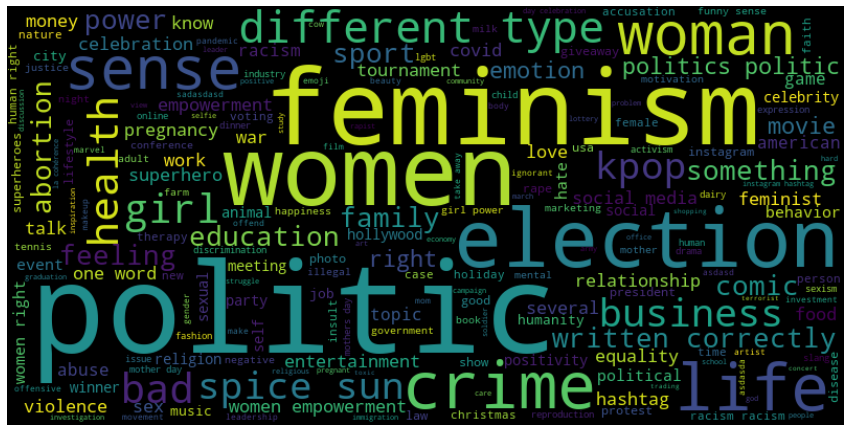

In [144]:
build_topic_cloud(insta_topics)

In [66]:
pool_id = "24002052"
process_results(pool_id, "instagram")

22
morning, capture, awful, stick, bad, superheroes, goddess, rid, throw, literally
0.4090909090909091
['photo tag', 'politic', "God's power", 'Goddess ', 'goddess', 'movie', "Don't know", 'superheroes', 'daily talks']
['anlamsız', 'words are inconsistent', 'does not make sense', 'more than one theme', 'sdasdasd', 'words are irrelevant', 'Words are irrelevant ', 'meaningless', 'LA COHÉRENCE', "Words don't make sense together.", 'Irrelevant words ', 'words are inconsistent', 'Some words are not related']
----------------
22
harley, divorce, hotbeverage, aware, cop, goddess, think, blessing, death, terrorist
0.2727272727272727
['bad', 'politic', 'divorce, terrorist ', 'bad', "Don't know", 'terrorist']
['anlamsız', 'Irrelevant', 'words are inconsistent', 'hotbeverage', 'does not make sense', 'more than one theme', 'sdasdasd', 'words are irrelevant', 'Words are irrelevant ', 'does not make sense', 'meaningless', 'LA COHÉRENCE', "Words don't make sense together.", 'Irrelevant words ', 'harl

tournament, andy, medal, tennis, achievement, gold, assumption, reporter, mistake, realise
0.7857142857142857
['Hchhxjxj', 'tournament, tennis tournament', 'sport field', 'tournament', 'wrong reporting during tournament', 'Tennis', 'sports', 'olympic', 'Sports', 'tennis', 'medal']
['words are irrelevant', 'meaningless', 'tennis', 'It is inconsistent']
----------------
14
touch, attack, wrong, sham, response, behavior, misogynistic, degree, constantly, believe
0.35714285714285715
['Hzjzjzj', 'behavior', 'misogynistic', 'Violence', 'wrong doing']
["No, these words don't make a topic", 'words are irrelevant', 'words are not connected', 'does not make sense', 'Not it is not\n', 'meaningless', 'irrelevant', 'It is inconsistent', 'behavior, misogynistic, degree']
----------------
16
womenincomics, finally, womenofcomics, marvel, superhero, sad, superheroes, harley, character, shave
0.5625
['Womenincomics', 'heros', 'list of superheroes', 'Character ', 'SUPERHEROES', 'Film characters', 'Comic

In [145]:
pool_id = "24004309"
process_results(pool_id, "twitter")

4
joytrain, mindfulness, selflove, joy, mentalhealth, selfcare, bullseyethat, gratitude, miao, awaken
0.25
['#selflove']
['No sence', "Doesn't make sense ", 'Irrelevant words']
----------------
4
earring, hot, flower, cute, unsafe, silver, etsy, handmade, vintage, gold
0.25
['Hand made things']
["Doesn't make sense ", 'Irrelevant', 'irrelevant']
----------------
4
rico, puerto, editorial, ding, nwe, ongoing, nair, hindu, obe, afal
0.0
[]
['No sence', "Doesn't make sense ", 'Irrelevant', 'irrelevant']
----------------
4
kin, loveislove, kindness, pic, continual, junk, reiterate, earth, click, madewithunity
0.0
[]
['No sence ', "Doesn't make sense ", 'Inconsistent words', 'irrelevant']
----------------
4
neatly, marginaliing, parental, menstruation, manbari, confident, hurt, harmful, abandon, happen
0.25
['Female issue']
["Doesn't make sense ", 'Inconsistent words', 'irrelevant']
----------------
5
kate, directorate, surgery, keynote, cook, ding, machinelea, favourite, imprison, graduate

0.0
[]
['irrelevant', 'words are irrelevant', 'not related']
----------------
3
immense, direction, generate, effort, derasachasauda, womanhood, empoweringwomen, elcinsangu, ge, powerofwomen
0.0
[]
['irrelevant', 'words are irrelevant', 'not related']
----------------
4
nwe, oo, revolution, luisma, afal, myanmar, storm, puerto, rico, kin
0.0
[]
['irrelevant', 'not related', 'Inconsistent', 'words not connected']
----------------
4
kintoxi, garitai, miao, madewithunity, hui, irato, pitchmygame, danimation, iratokitoxi, blu
0.0
[]
['irrelevant', 'not related', 'Spelling mistakes', 'words not connected']
----------------
4
cytotec, pampalaglag, transaction, sink, ship, procedure, med, authentic, fb, soundcloud
0.0
[]
['irrelevant', 'not related', 'Inconsistent', 'words not connected']
----------------
4
fintech, apo, ding, productivity, rico, puerto, invite, gain, recognied, chanel
0.0
[]
['irrelevant', 'not related', 'Inconsistent', 'words not connected']
----------------
4
handbags, han

----------------
1
1
1
1
1
1
1
1
1
1
3
knit, malesign, acceptance, pension, product, personshrugging, flashback, perfectwomen, proportion, york
0.0
[]
['irrelevant', 'not related', 'words not connected']
----------------
3
wealthy, killthebill, absurd, flee, heavily, recruit, angela, cuban, square, vacancy
0.0
[]
['irrelevant', 'not related', 'words not connected']
----------------
3
crawl, outlaw, kerb, clause, eliminate, homicide, suppose, everyt, woo, superpower
0.0
[]
['irrelevant', 'not related', 'words not connected']
----------------
3
britney, intransi, village, winter, absurd, colombia, wisdom, cake, absorb, biafra
0.0
[]
['irrelevant', 'not related', 'words not connected']
----------------
3
pertains, ding, silk, hclswlobp, codingpics, lowcode, pune, trick, nodejs, knit
0.0
[]
['irrelevant', 'not related', 'words not connected']
----------------
1
1
1
1
1
1
1
1
1
1
2
massacre, orig, editorial, appeasement, enables, vulnerability, est, pfizer, standup, ge
0.0
[]
['irrelevant',

joytrain, mindfulness, selflove, joy, mentalhealth, selfcare, bullseyethat, gratitude, miao, awaken
['#selflove']
----------------
earring, hot, flower, cute, unsafe, silver, etsy, handmade, vintage, gold
['Hand made things']
----------------
----------------
----------------
neatly, marginaliing, parental, menstruation, manbari, confident, hurt, harmful, abandon, happen
['Female issue']
----------------
kate, directorate, surgery, keynote, cook, ding, machinelea, favourite, imprison, graduate
['Impressive ']
----------------
ring, pop, trend, necklace, handmade, dial, dankmemes, womensafety, earring, fruit
['Necklace ', 'Jelwery shop']
----------------
flashback, emma, york, united, nation, speech, actress, powerful, meeting, inequality
['Speech on inequality', 'Politics', 'Actress']
----------------
----------------
homicide, double, apply, pregnant, murder, knit, silk, contemplate, kill, absorb
['Crime']
----------------
----------------
----------------
bffs, misconduct, come, know

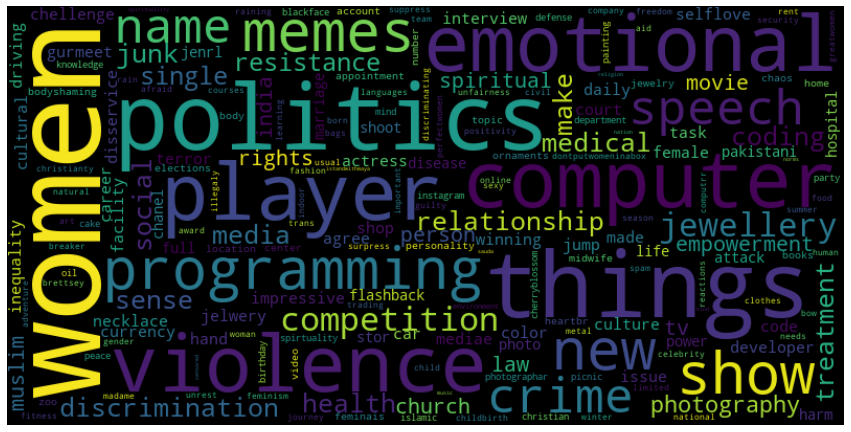

In [146]:
pool_id = "24004309"
twitter_topics = get_topic_names(pool_id, "twitter")
build_topic_cloud(twitter_topics)

In [68]:
pool_id = "24005625"
process_results(pool_id, "tiktok_desc")

15
water, dry, lemon, cup, towel, add, bake, oil, butter, wash
0.7333333333333333
['Bake', 'skin care', 'Liquids', 'sssssssss', 'cook or bake', 'Kitchen', 'Recipe', 'Kitchen workout', 'Skin care', 'household', 'Skin care']
['words not make sense', 'meaningless', 'irrelevant', 'nonsense']
----------------
15
throw, alien, goat, yell, couch, wallet, swim, pool, flight, bathroom
0.26666666666666666
['alien,fligh', 'Summer', 'sssssssssss', 'Bathing']
['Different type of words', 'does not make sense', 'meaningless', 'has no sense', "Words don't make sense together", 'irrelevant', 'nonsense', 'Words doesnt make sense together', 'Inconsistency', 'no sense', 'No sense']
----------------
15
everytime, fetus, waste, feel, gosh, cry, miscarriage, potato, yell, abortion
0.2
['miscarriage,abortion', 'sssssssssssssss', 'loss of a baby']
['Different type of words', 'does not make sense', 'Irrelevant', 'meaningless', "Words don't make sense together", 'irrelevant words (potato)', 'nonsense', 'Words do

----------------
10
hairstyle, hair, braid, metal, band, bun, edge, tie, style, wear
0.8
['\nhair stylist', 'related', ' hair, braid, metal,', 'Hairstyle', 'hair care and styling', 'Hair accessories', 'Regarding hairstyle.', 'fashion']
['No any same topic ', 'different']
----------------
10
news, fox, terrorist, cnn, wel, allegation, trump, supporter, arrest, wat
0.5
['news tv', 'fox, terrorist, cnn ', 'Political events', 'Violence.', 'election']
['not related', 'No any same topic ', 'irrelevant', 'typographical error', 'different']
----------------
10
vegan, meat, veganism, cheese, vegetarian, food, lilienthal, eat, meal, chicken
0.9
['food', 'related\n', 'Veganism ', 'vegan, meat, veganism, ', 'food', 'vegetarian', 'Food types', 'Fooding items.', 'vegetarian']
['different']
----------------
5
acid, skin, dry, vitamin, water, routine, skincare, oil, wash, acne
0.8
['vitamin', 'dermal issues', 'skincare', 'skincare']
['No any same topic ']
----------------
5
honest, feel, reason, feeli

In [147]:
pool_id = "24005625"
tiktok_desc_topics = get_topic_names(pool_id, "tiktok_desc")

water, dry, lemon, cup, towel, add, bake, oil, butter, wash
['Bake', 'skin care', 'Liquids', 'sssssssss', 'cook or bake', 'Kitchen', 'Recipe', 'Kitchen workout', 'Skin care', 'household', 'Skin care']
----------------
throw, alien, goat, yell, couch, wallet, swim, pool, flight, bathroom
['alien,fligh', 'Summer', 'sssssssssss', 'Bathing']
----------------
everytime, fetus, waste, feel, gosh, cry, miscarriage, potato, yell, abortion
['miscarriage,abortion', 'sssssssssssssss', 'loss of a baby']
----------------
bury, alive, dead, child, father, death, combine, god, spirit, sister
['Death ', 'Church', 'ssssssssss', 'religion', 'lost', 'Spirituality', 'burying child alive', 'Life', 'death', 'Burial']
----------------
discriminate, racism, minority, ppl, race, poc, oppression, white, identity, community
['discriminate, racism, minority, ppl, race, poc, oppression, white, identity, community', 'Racism', 'sssssssssss', 'racism', 'oppression of people', 'Racism\n', 'racism', 'Society', 'racism'

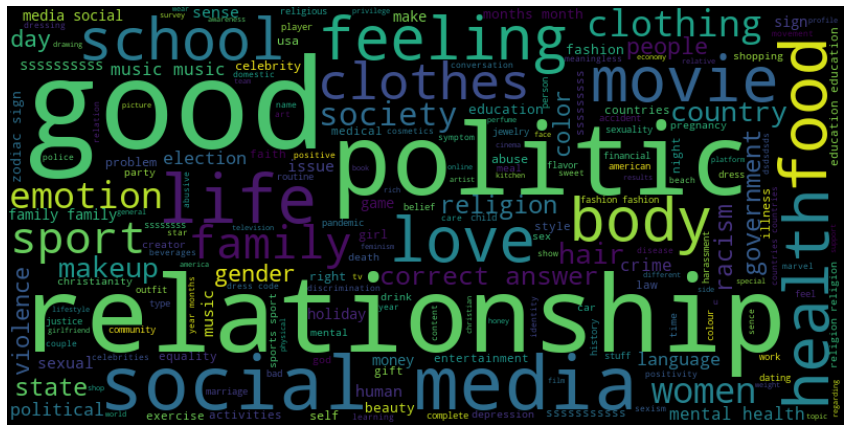

In [148]:
build_topic_cloud(tiktok_desc_topics)

In [69]:
pool_id = "24006390"
process_results(pool_id, "tiktok_subtitles")

7
sword, prie, wand, dental, nobel, pentacle, badass, card, deck, tarot
0.42857142857142855
['dentist', 'Psychic', 'Card']
['dental, nobel, pentacle, badass, card, ', 'different types of words', 'Does not make sense', 'does not relate']
----------------
7
prank, penetration, funny, joke, laugh, stag, allergic, sing, anus, insufferable
0.14285714285714285
['Laugh']
['penetration', 'allergic, sing, anus, insufferable', 'No sense', 'different types of words', 'Does not make sense', 'does not relate']
----------------
7
statistic, data, rate, stats, homicide, statistically, suicide, number, prevalence, survey
0.7142857142857143
['statistic', 'Surveyor', 'Death statistics', 'Data', 'homicide statistics']
['different types of words', 'Does not make sense']
----------------
7
crone, maiden, wisdom, goddess, nurture, archetype, menopause, warrior, upside, phase
0.0
[]
['crone and phase', 'menopause, warrior, upside, phase', 'No sense', 'different types of words', 'Does not make sense', "I don'

1.0
['events', 'occation', 'Birthday wish ', 'celebration', 'decoration', 'datas comemorativas']
[]
----------------
6
bystander, mat, oddly, cpr, lid, christianity, pray, intervene, destination, prayer
0.16666666666666666
['prayer']
[' does not make sense', 'different', 'Meaningless Words ', 'different things', 'nao faz sentido']
----------------
6
distract, distraction, soccer, audiobooks, basketball, meditate, ha, meditation, breathe, intrusive
0.16666666666666666
['audio books']
['it does not make sence', 'does not relate', 'audiobooks,', "This list doesn't make sense together", "words doesn't make sense together."]
----------------
6
tourist, airport, destination, travel, mushroom, officer, nearby, town, teammate, flight
0.3333333333333333
['tourist', 'Travelling']
['it does not make sence', 'does not relate', 'mushroom, ', "words doesn't make sense together."]
----------------
6
worship, deity, christianity, blanket, pray, god, goddess, paganism, christian, catholicism
0.83333333

In [138]:
pool_id = "24006390"
tiktok_subtitles_topics = get_topic_names(pool_id, "tiktok_subtitles")

sword, prie, wand, dental, nobel, pentacle, badass, card, deck, tarot
['dentist', 'Psychic', 'Card']
----------------
prank, penetration, funny, joke, laugh, stag, allergic, sing, anus, insufferable
['Laugh']
----------------
statistic, data, rate, stats, homicide, statistically, suicide, number, prevalence, survey
['statistic', 'Surveyor', 'Death statistics', 'Data', 'homicide statistics']
----------------
----------------
illness, mental, depression, medication, diagnose, chronic, disorder, suicidal, diagnosis, anxiety
['being ill', 'mental health', 'Mental illness', 'illness', 'disease']
----------------
teacher, grade, student, school, elementary, classroom, classmate, class, graduate, kindergarten
['graduation', 'School', 'Schooling', ' related', 'educational', 'education.']
----------------
escort, simpson, molestation, christmas, superstition, scene, rumour, prostitution, murder, convict
['related']
----------------
ex, emphasis, poet, abusive, cheating, familys, exes, boundary,

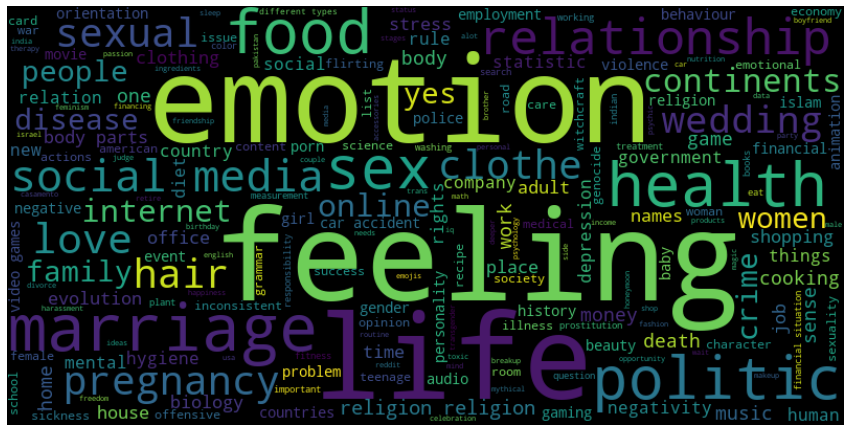

In [153]:
build_topic_cloud(tiktok_subtitles_topics)

In [70]:
pool_id = "24005215"
process_results(pool_id, "reddit")

20
antitheist, goodwithoutgod, antireligion, godless, secularhumanist, skeptic, agnostic, heathen, heretic, exchristians
0.6
['Religion', 'religion', 'Relegious View', 'religious', "doesn't make sense", 'Infidel', 'relevent', 'Christian', 'Ant', 'Non believer ', 'Goodwithoutgod', 'Good habit', 'Yes related topic']
['Diffrent', 'no sense', 'the words are spelled or written incorrectly ', 'not related', "I don't understand", 'Do not make a sense', 'not any meaning', 'Contrasting words']
----------------
20
commie, howdyisokay, marxism, marxist, antifa, leftism, leftists, communist, toriesout, marx
0.3
['Movement', "doesn't make sense", 'sense', 'relevent', 'Community', 'Commie', 'Yes related topic']
['different topics', 'irrelevant', 'Diffrent', ' words are spelled or written incorrectly.', "doesn't make sense", 'words are inconsistent, words are irrelevant, words are spelled or written incorrectly', 'the words are spelled or written incorrectly ', 'irrelevant', 'Commie, howdyisokay,anti

In [157]:
pool_id = "24005215"
reddit_topics = get_topic_names(pool_id, "reddit")

antitheist, goodwithoutgod, antireligion, godless, secularhumanist, skeptic, agnostic, heathen, heretic, exchristians
['Religion', 'religion', 'Relegious View', 'religious', "doesn't make sense", 'Infidel', 'relevent', 'Christian', 'Non believer ', 'Goodwithoutgod', 'Good habit', 'Yes related topic']
----------------
commie, howdyisokay, marxism, marxist, antifa, leftism, leftists, communist, toriesout, marx
['Movement', 'sense', 'relevent', 'Community', 'Commie', 'Yes related topic']
----------------
dibujo, draw, arte, art, artist, artwork, tiktokartist, digitalart, illustration, painting
['Art', 'art', "doesn't make sense", 'art', 'Art', 'Painting ', 'artist', 'Painting', 'Painting', 'Art sence', 'Artwork', 'Yes related topic']
----------------
deutschland, germany, danke, german, switerland, furdichseite, schule, frau, austria, diese
['German', 'german countries', 'europian', 'country', 'German', 'relevent', 'Danke', 'Germans', 'Country', 'Austria', 'Yes related topic']
-----------

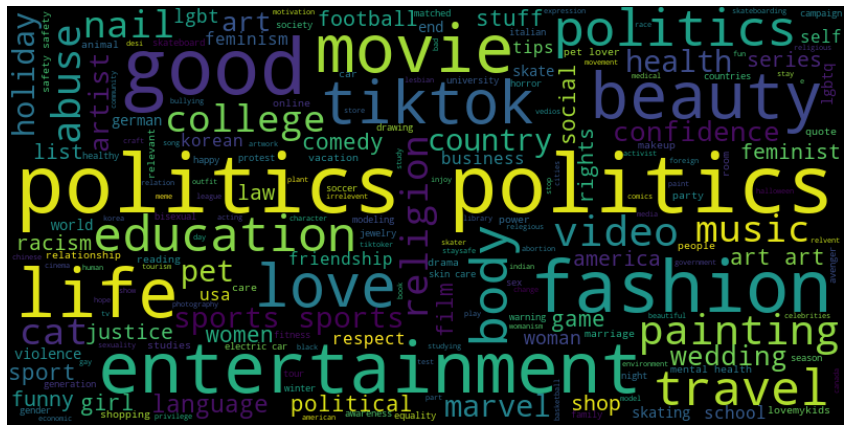

In [167]:
build_topic_cloud(reddit_topics)

In [307]:
pool = toloka_client.clone_pool('23949061')
pool_id = pool.id

with open('bertopic/instagram_bertopic.json') as json_file:
    data = json.load(json_file)
    
tasks = []
for d in data:
    words = d['words'][:10]
    intersection = list(set(words) & set(additional_stop_words))
    if len(intersection) == 0:
        txt = ', '.join(words)
#         print(txt)
#         print()
        tt = toloka.task.Task(input_values={'comment': txt})
        tasks.append(tt)
        
_chunks = list(chunks(tasks, 6))
print(len(_chunks))
task_suites = []
for ch in _chunks:
    new_tasks_suite = toloka.task_suite.TaskSuite(
        pool_id=pool_id,
        tasks=ch,
        overlap=3
    )
    task_suites.append(new_tasks_suite)
for t in task_suites:
    res = toloka_client.create_task_suite(t)
#     print(res)
insta_bert_pool = toloka_client.open_pool(pool_id)

85


In [308]:
pool = toloka_client.clone_pool('23949061')
pool_id = pool.id

with open('bertopic/twitter_bertopic.json') as json_file:
    data = json.load(json_file)
    
tasks = []
for d in data:
    words = d['words'][:10]
    intersection = list(set(words) & set(additional_stop_words))
    if len(intersection) == 0:
        txt = ', '.join(words)
#         print(txt)
#         print()
        tt = toloka.task.Task(input_values={'comment': txt})
        tasks.append(tt)
        
_chunks = list(chunks(tasks, 6))
print(len(_chunks))
task_suites = []
for ch in _chunks:
    new_tasks_suite = toloka.task_suite.TaskSuite(
        pool_id=pool_id,
        tasks=ch,
        overlap=3
    )
    task_suites.append(new_tasks_suite)
for t in task_suites:
    res = toloka_client.create_task_suite(t)
#     print(res)
twitter_bert_pool = toloka_client.open_pool(pool_id)

139


In [309]:
pool = toloka_client.clone_pool('23949061')
pool_id = pool.id

with open('bertopic/reddit_bertopic.json') as json_file:
    data = json.load(json_file)
    
tasks = []
for d in data:
    words = d['words'][:10]
    intersection = list(set(words) & set(additional_stop_words))
    if len(intersection) == 0:
        txt = ', '.join(words)
#         print(txt)
#         print()
        tt = toloka.task.Task(input_values={'comment': txt})
        tasks.append(tt)
        
_chunks = list(chunks(tasks, 6))
print(len(_chunks))
task_suites = []
for ch in _chunks:
    new_tasks_suite = toloka.task_suite.TaskSuite(
        pool_id=pool_id,
        tasks=ch,
        overlap=3
    )
    task_suites.append(new_tasks_suite)
for t in task_suites:
    res = toloka_client.create_task_suite(t)
#     print(res)
reddit_bert_pool = toloka_client.open_pool(pool_id)

154


In [310]:
pool = toloka_client.clone_pool('23949061')
pool_id = pool.id

with open('bertopic/tiktok_desc_bertopic.json') as json_file:
    data = json.load(json_file)
    
tasks = []
for d in data:
    words = d['words'][:10]
    intersection = list(set(words) & set(additional_stop_words))
    if len(intersection) == 0:
        txt = ', '.join(words)
#         print(txt)
#         print()
        tt = toloka.task.Task(input_values={'comment': txt})
        tasks.append(tt)
        
_chunks = list(chunks(tasks, 6))
print(len(_chunks))
task_suites = []
for ch in _chunks:
    new_tasks_suite = toloka.task_suite.TaskSuite(
        pool_id=pool_id,
        tasks=ch,
        overlap=3
    )
    task_suites.append(new_tasks_suite)
for t in task_suites:
    res = toloka_client.create_task_suite(t)
#     print(res)
tiktok_bert_pool = toloka_client.open_pool(pool_id)

345


In [313]:
insta_bert_pool.id

'24034580'

In [ ]:
process_results(twitter_bert_pool.id, "twitter_bert")

In [ ]:
process_results(reddit_bert_pool.id, "reddit_bert")

In [ ]:
process_results(tiktok_bert_pool.id, "tiktok_bert")

In [46]:
additional_stop_words = [
    'ayni', 'gibi', 'hic', 'bir', 'ama', 'yok', 'degil', 'yemek', 'benim', 'cocuk',
    'asi', 'pero', 'mujer', 'hombre', 'porque', 'esta', 'una', 'por', 'mujeres', 'ma',
    'ko', 'kya', 'nhi', 'aur', 'kuch', 'bhi', 'ka', 'hai', 'ho', 'toh',
    'isso', 'voce', 'te', 'sao', 'um', 'ja', 'seu', 'mesmo', 'nao', 'bem',
    'este', 'del', 'todo', 'hay', 'casa', 'pero', 'el', 'mujeres', 'por', 'la',
    'und', 'die', 'ik', 'isi', 'cocuk', 'hem', 'erkek', 'erkekler', 'kadin', 'thinkingface',
    'pour', 'au', 'une', 'ce', 'de', 'je', 'du', 'sa', 'qui', 'par', 'ka', 'tem',
    'isso', 'bem', 'mesmo', 'maravilhosa', 'esse', 'essa', 'tem', 'sao', 'minha', 'nao',
    'xx', 'wenn', 'ihr', 'bei', 'eine', 'schon', 'euch', 'amongus', 'macht',
    'che', 'sono', 'perche', 'io', 'gli', 'anche', 'questo', 'tutti', 'fare', 'essere',
    'itu', 'tapi', 'bisa', 'aku', 'jangan', 'ini', 'kamu', 'yang', 'tidak', 'jadi',
    'jak', 'tym', 'tego', 'jest', 'ze', 'nie', 'kiedy', 'tak', 'od',
    'kamu', 'harus', 'tidak', 'saya', 'akan', 'jika', 'bisa', 'udah', 'lebih', 'lagi',
    'cam', 'tego', 'ze', 'jak', 'jest', 'tym', 'nie', 'long', 'kiedy', '35th', 'po', 'nigga',
    'oi', 'hrc', 'lisa', 'sooooooo', 'yaaa', 'sc', 'alls', '26th', 'aa', 'foldedhandsfoldedhandsfoldedhands',
    'yep', 'x1f48e', 'shou'
]

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [54]:
import json

def send_hdp(file):
    pool = toloka_client.clone_pool('23949061')
    pool_id = pool.id

    with open(file) as json_file:
        data = json.load(json_file)

    tasks = []
    for d in data:
        print(d)
        words = d
#         //.split(', ')
        intersection = list(set(words) - set(additional_stop_words))
        print(d)
        if len(intersection) > 0:
            txt = ', '.join(intersection)
            print(txt)
            print()
            tt = toloka.task.Task(input_values={'comment': txt})
            tasks.append(tt)

    _chunks = list(chunks(tasks, 5))
    print(len(_chunks))
    task_suites = []
    for ch in _chunks:
        new_tasks_suite = toloka.task_suite.TaskSuite(
            pool_id=pool_id,
            tasks=ch,
            overlap=3
        )
        task_suites.append(new_tasks_suite)
    for t in task_suites:
        res = toloka_client.create_task_suite(t)
    new_pool_tiktok_desc = toloka_client.open_pool(pool_id)
    return new_pool_tiktok_desc

In [55]:
hdp_instagram_pool = send_hdp('hdp_instagram_topics.json')

['norarachelart', 'autobiography', 'motherdaughter', 'recognied', 'english', 'intergenerational', 'depiction', '35th', 'po', 'nigga']
['norarachelart', 'autobiography', 'motherdaughter', 'recognied', 'english', 'intergenerational', 'depiction', '35th', 'po', 'nigga']
recognied, intergenerational, autobiography, depiction, motherdaughter, norarachelart, english

['winglet', 'madame', 'clappinghandslightskintone', 'mothersdayweekend', 'central', 'unable', 'rosaparks', 'sleep', 'togetherness', 'crimp']
['winglet', 'madame', 'clappinghandslightskintone', 'mothersdayweekend', 'central', 'unable', 'rosaparks', 'sleep', 'togetherness', 'crimp']
clappinghandslightskintone, winglet, central, rosaparks, mothersdayweekend, unable, togetherness, crimp, madame, sleep

['bat', 'victimblaming', 'derange', 'hrc', 'sell', 'auto', 'igualdad', 'mark', 'oi', 'bittim']
['bat', 'victimblaming', 'derange', 'hrc', 'sell', 'auto', 'igualdad', 'mark', 'oi', 'bittim']
victimblaming, sell, igualdad, bat, bittim, 

In [56]:
hdp_twitter_pool = send_hdp('hdp_twitter.json')

['kitchen', 'supportsmallbusiness', 'flower', 'betrayal', 'shou', 'finance', 'grateful', 'imbalance', 'vax', 'effyourbeautystandards']
['kitchen', 'supportsmallbusiness', 'flower', 'betrayal', 'shou', 'finance', 'grateful', 'imbalance', 'vax', 'effyourbeautystandards']
betrayal, flower, grateful, vax, supportsmallbusiness, imbalance, finance, effyourbeautystandards, kitchen

['abc', 'disaster', 'lily', 'supportsmallbusinesses', 'teenager', 'growingheart', 'heterosexual', 'war', 'shop', 'management']
['abc', 'disaster', 'lily', 'supportsmallbusinesses', 'teenager', 'growingheart', 'heterosexual', 'war', 'shop', 'management']
management, teenager, supportsmallbusinesses, heterosexual, lily, growingheart, disaster, shop, abc, war

['sophia', 'weightloss', 'romance', 'symbol', 'foldedhands', 'yep', 'womenowned', 'business', 'dot', 'repair']
['sophia', 'weightloss', 'romance', 'symbol', 'foldedhands', 'yep', 'womenowned', 'business', 'dot', 'repair']
repair, symbol, foldedhands, sophia, rom

In [57]:
hdp_tiktok_subt_pool = send_hdp('hdp_tiktok_subtitles.json')

['relevant', 'apartment', 'unbelievably', 'bus', 'fictional', 'compassionate', 'error', 'sterling', 'stone', 'sharp']
['relevant', 'apartment', 'unbelievably', 'bus', 'fictional', 'compassionate', 'error', 'sterling', 'stone', 'sharp']
bus, sharp, sterling, error, apartment, relevant, stone, unbelievably, fictional, compassionate

['pursuit', 'thanos', 'threw', 'drain', 'liking', 'melody', 'triste', 'chipmunk', 'monster', 'duck']
['pursuit', 'thanos', 'threw', 'drain', 'liking', 'melody', 'triste', 'chipmunk', 'monster', 'duck']
melody, chipmunk, liking, pursuit, triste, monster, drain, duck, thanos, threw

['perspective', 'employment', 'dennis', 'egypt', 'superior', 'peggy', 'singular', 'rid', 'welcome', 'prend']
['perspective', 'employment', 'dennis', 'egypt', 'superior', 'peggy', 'singular', 'rid', 'welcome', 'prend']
egypt, peggy, dennis, singular, welcome, employment, perspective, superior, prend, rid

['international', 'hufflepuff', 'prophet', 'faut', 'sun', 'beyonce', 'el', 'pre

In [58]:
hdp_reddit_pool = send_hdp('hdp_reddit.json')

['leisure', 'league', 'societal', '5k', 'supervisor', 'anal', 'aba', 'classy', 'rewritten', 'direction']
['leisure', 'league', 'societal', '5k', 'supervisor', 'anal', 'aba', 'classy', 'rewritten', 'direction']
supervisor, aba, 5k, classy, leisure, anal, league, societal, direction, rewritten

['giggle', 'terroriing', 'blurry', 'omnipotent', 'satire', 'facing', 'disabled', 'oldie', 'metaphorically', 'ditch']
['giggle', 'terroriing', 'blurry', 'omnipotent', 'satire', 'facing', 'disabled', 'oldie', 'metaphorically', 'ditch']
omnipotent, giggle, metaphorically, blurry, oldie, terroriing, satire, disabled, ditch, facing

['embodies', 'capability', 'moronic', 'bottom', 'std', 'fine', 'bus', 'gps', 'celebs', 'knowland']
['embodies', 'capability', 'moronic', 'bottom', 'std', 'fine', 'bus', 'gps', 'celebs', 'knowland']
moronic, gps, bus, capability, celebs, bottom, std, fine, embodies, knowland

['incarnation', 'illustrate', 'consequence', 'tru', 'sneak', 'saver', 'dunno', 'autistic', 'combinat

In [59]:
hdp_tiktok_videos = send_hdp('hdp_tiktok_videos.json')

['thiboy941', 'pjdivya', 'monde', 'donate', 'edp445', 'antirape', 'mikasa', 'topmodel', 'oldman', 'monsoon']
['thiboy941', 'pjdivya', 'monde', 'donate', 'edp445', 'antirape', 'mikasa', 'topmodel', 'oldman', 'monsoon']
monsoon, mikasa, topmodel, pjdivya, antirape, donate, edp445, monde, thiboy941, oldman

['hatecrime', 'roach', 'lebronjames', 'salmankhan', 'bby', 'neighbor', 'nothink', 'damonsalvatore', 'ysrcp', 'wandamaximoff']
['hatecrime', 'roach', 'lebronjames', 'salmankhan', 'bby', 'neighbor', 'nothink', 'damonsalvatore', 'ysrcp', 'wandamaximoff']
lebronjames, wandamaximoff, roach, nothink, hatecrime, bby, ysrcp, salmankhan, damonsalvatore, neighbor

['tiktokindia', 'hbd', 'babyshark', 'mehndi', 'cryingcat', 'newyearnewmio', 'nailpolish', 'caseyrosenberg', 'onlineclass', 'lgbtqrights']
['tiktokindia', 'hbd', 'babyshark', 'mehndi', 'cryingcat', 'newyearnewmio', 'nailpolish', 'caseyrosenberg', 'onlineclass', 'lgbtqrights']
newyearnewmio, cryingcat, lgbtqrights, nailpolish, caseyrosen

In [72]:
process_results(hdp_tiktok_videos.id, "tiktok_videos_hdp")

3
trumpisadisgrace, newfriends, ariel, squadgoals, copitodenieve, sole, enfin, sich, smallbi, tide
0.0
[]
['Not clear', "Ariel doesn't make sense", 'no sense']
----------------
3
ooh, gachadirty, brandy, carson, transphobic, diss, facewithtearsofjoyfacewithtearsofjoyfacewithtearsofjoy, tiktokfamily, f4, mountain
0.0
[]
['Words merged together', "ooh doesn't make 6", 'no sense']
----------------
3
stats, visual, creativemakeup, bike, dash, thisishalloween, liberte, oddlysatifying, fyppppppppppp, muaythai
0.3333333333333333
['Leisure']
["stats doesn't make sense", 'no sense']
----------------
3
klausmikaelson, afford, clappinghandsclappinghandsclappinghands, transinclusive, bakugoucosplay, maketheleap, boob, tinyhouse, ilovechina, kommt
0.0
[]
['Not clear', "afford doesn't make sense", 'no sense']
----------------
3
tmrw, serenavanderwoodsen, makeblackhistory, hairspray, emogirl, grammar, cristiano, streamingwars, takemetochurch, pcq
0.0
[]
['Not clear', "tmrw doesn't make sense", 'no se

In [73]:
process_results(hdp_reddit_pool.id, "reddit_videos_hdp")

3
dealing, bollock, stepdaughter, intergenerational, hall, language, dominatrix, export, recklessly, actively
0.0
[]
["export doesn't make sense", 'It does not make sense together.', 'irrelevant']
----------------
3
sauna, hater, woodworking, rub, circumcise, vocally, withstand, follower, ida, efficiently
0.0
[]
["follower doesn't make sense", 'It does not make sense together.', 'irrelevant']
----------------
3
citation, dysphoria, insecure, keto, source, convolute, hoover, latina, assert, negotiate
0.0
[]
["insecure doesn't make sense", 'It does not make sense together.', 'irrelevant']
----------------
3
physique, tot, inherited, publishing, rocker, subsidy, ralph, decry, gander, mushroom
0.0
[]
["horoscope doesn't make sense", 'It does not make sense together.', 'irrelevant']
----------------
3
horoscope, churn, small, handwrite, gush, fighter, prudish, tricky, fems, demo
0.0
[]
["fighter doesn't make sense", 'It does not make sense together.', 'irrelevant']
----------------
3
superv

In [74]:
process_results(hdp_tiktok_subt_pool.id, "tiktok_subt_hdp")

3
torn, klasse, leopard, famous, duty, discus, arrest, traditional, manipulative, tortilla
0.0
[]
['no sense', 'words are inconsistent.', 'Words are different']
----------------
3
sloth, torn, taxpayer, croire, colonier, tenido, consent, military, reaction, terminar
0.0
[]
['no sense', 'some words are wrong spelling.', 'Words are different']
----------------
3
overthrow, stare, forgets, consideration, lanyard, plot, disaster, childhood, shove, bitte
0.0
[]
['no sense', 'words are inconsistent.', 'Words are irrelevant']
----------------
3
distinct, creyendo, part2, felony, hon, decor, daddy, scary, momo, pinky
0.0
[]
['no sense', 'words are inconsistent.', 'Words are different']
----------------
3
workout, declaration, baddie, propoganda, analying, dictionary, menos, knight, stiff, biddy
0.0
[]
['no sense', 'words are inconsistent.', 'Words are different']
----------------
3
2a, dando, escorpiao, explain, r, mistreat, funnier, s, paytas
0.0
[]
['words are inconsistent.', "2a doesn't mak

In [75]:
process_results(hdp_twitter_pool.id, "twitter_subt_hdp")

3
commerce, january, revenue, farmersprotest, jody, smilingface, constant, wolf, defender, alternative
0.0
[]
['Unrelated words', 'Some non related words are there', 'Different types of words']
----------------
3
lightskintone, nature, outrage, collaborative, nee, jenny, novaccinepassportsanywhere, terf, kindness, musician
0.3333333333333333
['Behavioral features']
['Unrelated words', 'Different types of words']
----------------
3
anniversary, ttrpg, humanrightsviolations, prisoner, louise, method, sweden, pleadingface, ci, filmmaker
0.0
[]
['Unrelated words', 'Some non related words are there', 'Different types of words']
----------------
3
slow, experimental, vegan, separatism, aapi, edit, grad, megaphone, doug, partner
0.0
[]
['Unrelated words', 'Some non related words are there', 'Different types of words']
----------------
3
neighborhood, appal, olympics, affiliate, morningmotivation, justin, mom, inter, dye, insurance
0.0
[]
['Unrelated words', 'Some non related words are there',

In [76]:
process_results(hdp_instagram_pool.id, "instagram_subt_hdp")

4
rouge, sylvia, bryant, todas, pirate, imaginary, vent, transphobia, humbly, debatenight
0.25
['Incredible']
['It does not make sense together.', 'douse not make sense', 'words are irrelevent']
----------------
4
tina, saam, ideology, misconception, 6ix9ine, persongettingmassagelightskintone, receives, openhandsdarkskintone, contentstrategy, terrible
0.0
[]
['It does not make sense together.', "Beacuse the words can't make sense.", 'douse not make sense', 'words are different']
----------------
4
vp, enrich, unbossed, slew, sam, manufacture, elbow, hiddenabuse, grandad, toronto
0.25
['Good.']
['It does not make sense together.', 'irrelevant', 'words are irrelevent']
----------------
4
wore, ableism, loveyourselffirst, afloat, shotgun, andy, cuck, barismuratyagci, trabalhar
0.25
['Amazing.']
['It does not make sense together.', 'douse not make sense', 'words are different']
----------------
4
rockstar, silky, hypocrisy, sheroes, ethic, obrigada, theriseofthewomanequalstheriseofthenatio